# SECOP II - Modelación

En el presente notebook se realizan las pruebas para entrenar y guardar modelos predictivos con los cuales se pretende detectar anormalidades en la contratación pública de Bogotá. Con tal objetivo, en este punto se usa como insumo la base de datos SECOPII_Master(_2), creada previamente. Base con la cual se proceden a realizar modelos de clasificación binarios para 3 diferentes variables objetivo que determinan si el contrato tuvo alguna adición del respectivo tipo o no; `Tuvo_adiciones_valor`,`Tuvo_adiciones_tiempo` y `Tuvo_adiciones`. Adicionalmente, se realizan modelos teniendo en cuenta todos los contratos así como modelos con datos diferenciados por el tipo de contrato como prestación de servicios.

Los modelos generados son guardados en la carpeta `created_data/trained_models` en el directorio, así mismo, los datos usados, *SECOP_II_Master2*, se encuentra el la carpeta `created_data`.

- En los AIC y BIC domina el efecto del número de variables.
- Los resultados de las duraciones (días entre A y B fecha) como variables relevantes son consistentes con el documento de Gallego, Rivero, Martinez (2018).
-------

Posible trabajo posterior (No realizado durante el proyecto)
- Balancear hacia arriba los datos para modelos de contratos diferentes a prestación de servicio debido al bajo número de observaciones.
- Buscar arboles de inferencia condicional.
- Probar el desempeño de los modelos en datos de prueba no balanceados.
- Algoritmo SMOTE para balanceo.

In [35]:
import sys
print(sys.executable)
print(sys.getdefaultencoding())

c:\Users\andres.salazar\anaconda3\envs\vigia_art\python.exe
utf-8


In [36]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

# sklearn 0.24.1
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier 
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn import tree

import joblib

In [37]:
os.getcwd()

'd:\\vigia\\articulo\\vigia_datos'

In [38]:
base = pd.read_csv("created_data/SECOPII_Master_2.csv")

base = base.dropna()

# Codigo Segmento Categoria Principal categórica
base['Codigo Segmento Categoria Principal'] = base['Codigo Segmento Categoria Principal'].astype('O')

In [39]:
base.shape

(80306, 41)

In [40]:
base.head(2)

,ID Contrato,Nombre Entidad,Sector,Entidad Centralizada,Tipo de Contrato,Modalidad de Contratacion,Justificacion Modalidad de Contratacion,TipoDocProveedor,Es Grupo,Es Pyme,...,Proporcion pagada adelantado,Saldo CDP respecto Valor,Grupo categoria principal,Tipo Empresa Proveedor Resumido,Tiene_variables_portafolio,Dias Proceso Contratacion Abierto,Mes de Publicacion del Proceso,Tuvo_adiciones_valor,Tuvo_adiciones_tiempo,Tuvo_adiciones
0,CO1.PCCNTR.1442517,UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚ...,Ambiente y Desarrollo Sostenible,Descentralizada,Prestación de servicios,Contratación directa,ServiciosProfesionales,Cédula de Ciudadanía,No,No,...,0.0,0.0,Servicios administrativos,Persona Natural colombiana,1,0.0,Mar,0,0,0
1,CO1.PCCNTR.890256,INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE,Cultura,Descentralizada,Prestación de servicios,Contratación directa,ServiciosProfesionales,Cédula de Ciudadanía,No,No,...,0.0,6.0,Servicios administrativos,Persona Natural colombiana,1,0.0,Mar,0,0,0


**Listados de variables**

In [41]:
#Listado de variables a realizar one hot encoding sin incluir "Tipo de Contrato"
vars_categoricas = ["Sector", "Entidad Centralizada", "Modalidad de Contratacion", 
                    "Justificacion Modalidad de Contratacion", "TipoDocProveedor", 
                    "Es Grupo", "Es Pyme", "Habilita Pago Adelantado", "Liquidación",
                    "Obligación Ambiental", "EsPostConflicto", "Destino Gasto",
                    "Tipo Empresa Proveedor", "Mes Firma Contrato", 
                    "Grupo categoria principal", "Tipo Empresa Proveedor Resumido",
                    "Mes de Publicacion del Proceso", "Codigo Segmento Categoria Principal"
                   ]
#Variables a excluir al momento de entrenar modelos
vars_a_excluir = ["ID Contrato", "Saldo CDP", "Saldo CDP respecto Valor", "Nombre Entidad", 
                  "Tuvo_adiciones_valor", "Tuvo_adiciones_tiempo", "Tuvo_adiciones", 
                  "Tiene_variables_portafolio"
                 ]
#Variables a excluir para tener en cuenta solo sucesos antes de ejecución.
vars_ejecucion = ['Liquidación_No', 'Liquidación_Si', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
                  'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 
                  'Proporcion pagada adelantado', 'Codigo Segmento Categoria Principal_80000000'
                 ]
# Esta última variable se incluye para no repetir información en los modelos sin variables de ejecución dado que está la
# variable del grupo equivalente.

## Funciones creadas
Conjunto de funciones creadas debido a los procesos repetitivos realizados

**Funciones útiles para mostrar resultados de modelos**

In [42]:
# Gráficas
def corr_Matrix(data):
    '''
    Gráfica la matríz de correlación entre todas las variables 
    de la base de datos usada.
    '''
    f,ax = plt.subplots(figsize = (15,14))
    sns.heatmap(data.corr(),cmap = 'ocean_r', annot = True, cbar = False )
    ax.set_title('Correlation matrix')
    plt.show()


def plot_ROC(model, X_test, y_test, scaler, model_name='Model', figsize=(5,3)):
    '''
    Gráfica la curva ROC y calcula el AUC para un modelo entrenado dados unos datos de prueba.
    Entradas:
            model: modelo sklearn entrenado del que se usa el método predict_proba()
            X_test: variables independientes de prueba.
            Y_test: variable dependiente de prueba.
            scaler: objeto preprocessing.StandardScaler() entrenado junto al modelo para escalar X_test.
            model_name: string con el nombre del modelo que se pasa para usar como leyenda de la curva ROC
    Salida:
            Gráfica curva ROC e impresión del AUC.
    '''
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(scaler.transform(X_test))
    lr_probs = lr_probs[:, 1]
    
    lr_auc = roc_auc_score(y_test, lr_probs)
    print("Model: ROC AUC = {:1.3f}".format(lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.figure(figsize=figsize)
    plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()
    
    
def plot_CM(y_true, y_pred, plot=False, title='Matríz de confusión (1: adición)',
           xlabel='Predicción', ylabel='Observación', tickslabel=['No','Sí'], 
           savedir=None):
    '''
    Tabla de matríz de confusión
    '''
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index = tickslabel, columns = tickslabel)
    cm_df.index.name = ylabel; cm_df.columns.name = xlabel
    
    # Visualizando la matriz de confusión como gráfica
    if plot==True:
        sns.heatmap( cm_df, 
                    annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
                    cbar=False, square=True, linecolor='black', linewidths=0.2 )
        plt.title(title)
        plt.xlabel(xlabel, fontsize=13)
        plt.ylabel(ylabel, fontsize=13)
        if savedir:
            plt.savefig(savedir)
        plt.show()
    else:
        display(cm_df)
        return cm_df

El balanceo de los datos se decide hacer mediante la reducción de las observaciones para las cuales la variable objetivo toma el valor menos frecuente. Esto debido a que se tienen suficientes observaciones y no se encontró mejoría en el desempeño al aumentar el número de muestras.

In [43]:
def balance(base, target, seed=123):
    '''
    Función para balancear las bases de datos hacia el valor de la variables objetivo con menos observaciones.
    Entradas:
            base: base de pandas a balancear.
            target: nombre de la variable objetivo respecto a la que se balanceará.
    Salida:
            df_downsample: base balanceada.
    '''
    df_majority = base[base[target] == 0]
    df_minority = base[base[target] == 1]
    
    n = min(base[target].value_counts())
    df_majority_downsampled = resample(df_majority, replace = False, n_samples = n, random_state = seed)
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    return df_downsampled

**Funciones para ejecutar modelos**

In [44]:
def feature_selection(X, y, threshold=None):
    '''
    Selección de variables estadísticamente significativas mediante random forest
    Entradas: X, y: Variables independietes y dependientes como base y serie de pandas respectivamente.
    Salida: X_varSelec: Pandas dataframe solo con las variables significativas.
    '''
    #Random state de 42 para replicar modelos aleatorios y demás procedimientos.
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42), threshold=threshold) 
    sel.fit(X, y)
    
    variables_significativas = np.where(sel.get_support() == True)
    nombres_columnas = []
    for idx, i in enumerate(variables_significativas):
        nombres_columnas.append(X.columns[i])
    nombres_columnas = list(nombres_columnas[0])
    print("Variables estadísticamente significativas: \n{}".format(nombres_columnas))
    
    X_varSelec = sel.transform(X)
    X_varSelec = pd.DataFrame(X_varSelec, columns = nombres_columnas)
    
    return X_varSelec

def feature_selection_b(X, y):
    '''
    Selección de variables estadísticamente significativas mediante random forest
    Entradas: X, y: Variables independietes y dependientes como base y serie de pandas respectivamente.
    Salida: X_varSelec: Pandas dataframe solo con las variables significativas.
    '''
    #Random state de 42 para replicar modelos aleatorios y demás procedimientos.
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42), threshold="1.3*median") 
    sel.fit(X, y)
    
    variables_significativas = np.where(sel.get_support() == True)
    nombres_columnas = []
    for idx, i in enumerate(variables_significativas):
        nombres_columnas.append(X.columns[i])
    nombres_columnas = list(nombres_columnas[0])
    print("Variables estadísticamente significativas: \n{}".format(nombres_columnas))
    
    X_varSelec = sel.transform(X)
    X_varSelec = pd.DataFrame(X_varSelec, columns = nombres_columnas)
    
    return X_varSelec

def reg_log(X, y, get_train=False):
    '''
    Modelo de regresión logítica.
    Función para la realización de modelos mediante regresión logística. Imprime accuracy de la validación cruzada
    y datos de prueba , así como el recall en los datos de prueba.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            rl: modelo de regresión logística entrenado.
            X_test, y_test: Datos de prueba, transformados en el caso de X.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.
    '''
    #Random state de 42 para replicar modelos aleatorios y demás procedimientos.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    
    rl = LogisticRegression(max_iter = 500)
    vc = cross_val_score(rl, X_train, y_train, cv = 10, scoring = "accuracy")
    accuracy = vc.mean()
    print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )
    
    rl = LogisticRegression(max_iter = 500)
    rl.fit(X_train, y_train)

    # Mostrar métricas
    y_pred = rl.predict(scaler.transform(X_test))
    print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test, y_pred) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred) ))
    print("La precisión del test es: {:1.4f}".format( precision_score(y_test, y_pred) ))
    
    
    #Criterios de información
    y_prob = rl.predict_proba(X_train)
    LL = -log_loss(y_train, y_prob)
    K = len(rl.coef_[0]) + 1 
    N = X_train.shape[0]
    BIC = K*np.log(N) - 2*LL
    AIC = 2*K - 2*LL
    print("BIC: {:1.2f}".format(BIC))
    print("AIC: {:1.2f}".format(AIC))
    
    if get_train: # To get PDP
        return rl, X_test, y_test, y_pred, scaler, X_train, y_train
    else:
        return rl, X_test, y_test, y_pred, scaler


def random_forest(X, y, get_train=False):
    '''
    Modelo random forest para clasificación.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            arb: modelo de random forest entrenado.
            X_test, y_test: Datos de prueba.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    #Random state de 42 para replicar modelos aleatorios y demás procedimientos.
    arb = RandomForestClassifier(n_estimators = 100, random_state=42)
    arb.fit(scaler.transform(X_train), y_train)
    
    y_pred_arb = arb.predict(scaler.transform(X_test))
    
    print("Accuracy del test: {:1.4f}".format( accuracy_score(y_test, y_pred_arb) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred_arb) ))
    print("La precisión del test es: {:1.4f}".format( precision_score(y_test, y_pred_arb) ))

    if get_train: # To get PDP
        return arb, X_test, y_test, y_pred_arb, scaler, X_train, y_train
    else:
        return arb, X_test, y_test, y_pred_arb, scaler


In [45]:
base.dropna(inplace=True)

In [46]:
base.isna().sum().sort_values(ascending=False).head(10)

ID Contrato                             0
Codigo Segmento Categoria Principal     0
Valor acumulado multas SIC proveedor    0
Tipo Empresa Proveedor                  0
Dias Inicio-Firma Contrato              0
Dias Fin-Inicio Contrato                0
Dias Inicio-Firma Ejecucion             0
Dias Fin-Inicio Ejecucion               0
Dias Proveedor Inscrito                 0
Mes Firma Contrato                      0
dtype: int64

# `Tuvo_adiciones_valor` como variable respuesta

Compendio de procedimientos realizados.

In [47]:
#Balancear bases de datos
df_downsampled_AV = balance(base, "Tuvo_adiciones_valor")

# La terminación "_AV" en los nombres se refiere a Adiciones en Valor
y_down_AV = df_downsampled_AV["Tuvo_adiciones_valor"]

X_down = pd.get_dummies(data = df_downsampled_AV, columns = vars_categoricas+["Tipo de Contrato"])
X_down = X_down.drop(columns = vars_a_excluir)

In [48]:
X_down.shape

(28740, 208)

In [49]:
pd.crosstab(X_down['Tipo de Contrato_Prestación de servicios'], y_down_AV, margins=True, normalize='index')

Tuvo_adiciones_valor,0,1
Tipo de Contrato_Prestación de servicios,,
0,0.594878,0.405122
1,0.491426,0.508574
All,0.500000,0.500000


In [50]:
pd.crosstab(X_down['Tipo de Contrato_Prestación de servicios'], y_down_AV, margins=True)

Tuvo_adiciones_valor,0,1,All
Tipo de Contrato_Prestación de servicios,,,
0,1417,965,2382
1,12953,13405,26358
All,14370,14370,28740


El balanceo para los contratos no es tan bueno en contratos diferentes a prestación de servicios.

Formatos a tener al procesar los datos para modelos en app

In [51]:
vars = ['Valor del Contrato', 'Dias Inicio-Firma Contrato',
'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito',
'Sector_Cultura', 'Proveedores Invitados', 
'Dias Proceso Contratacion Abierto', 
'Grupo categoria principal_Servicios administrativos',
'Justificacion Modalidad de Contratacion_Decreto 092 de 2017']
X_down[vars].dtypes

Valor del Contrato                                               int64
Dias Inicio-Firma Contrato                                       int64
Dias Fin-Inicio Contrato                                         int64
Dias Inicio-Firma Ejecucion                                      int64
Dias Fin-Inicio Ejecucion                                        int64
Dias Proveedor Inscrito                                          int64
Sector_Cultura                                                   uint8
Proveedores Invitados                                          float64
Dias Proceso Contratacion Abierto                              float64
Grupo categoria principal_Servicios administrativos              uint8
Justificacion Modalidad de Contratacion_Decreto 092 de 2017      uint8
dtype: object

## Modelos sin diferenciar tipo de contrato

### Selección de variables
Estas se seleccionan mediante el clasificador de Random Forest donde se escogen aquellas vaiables estadísticamente significativas.

In [52]:
X_fselec = feature_selection(X_down, y_down_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Transporte', 'Sector_Vivienda, Ciudad y Territorio', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Liquidación_No', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Serv

Se realiza nuevamente la selección de variables entre aquellas arrojadas por la selección anterior con el proposito de reducir nuevamente el conjunto de variables relevantes.

In [53]:
X_fselec2 = feature_selection(X_fselec, y_down_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Cultura']


### Regresión logística

Utilizamos validación cruzada con 10 _folds_ y luego evaluamos sobre el conjunto de prueba.

**Regresión logística usando todas las variables independientes**

Modelo usando regresión logística con todas las variables
Accuracy para Regresión Logística con validación cruzada: 0.7971 
El accuracy del test es: 0.7998
La sensitividad(recall) del test es: 0.8209
La precisión del test es: 0.7877
BIC: 2071.97
AIC: 418.91


Predicción,No,Sí
Observación,,
No,3357,954
Sí,772,3539


Model: ROC AUC = 0.878


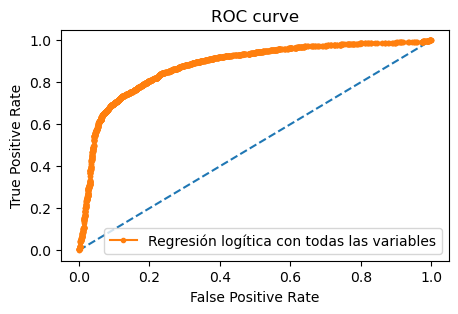

In [54]:
print('Modelo usando regresión logística con todas las variables')
regLog, X_test, y_test, y_pred, scaler = reg_log(X_down, y_down_AV)

plot_CM(y_test, y_pred)
plot_ROC(regLog, X_test, y_test, scaler, model_name='Regresión logítica con todas las variables')

**Regresión logística con variables de la primera selección de variables**

Accuracy para Regresión Logística con validación cruzada: 0.7882 
El accuracy del test es: 0.7898
La sensitividad(recall) del test es: 0.8135
La precisión del test es: 0.7767
BIC: 347.78
AIC: 70.95


Predicción,No,Sí
Observación,,
No,3303,1008
Sí,804,3507


Model: ROC AUC = 0.875


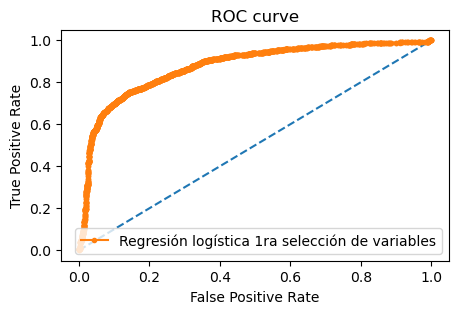

In [55]:
regLog2, X_test2, y_test2, y_pred2, scaler2 = reg_log(X_fselec, y_down_AV)

plot_CM(y_test2, y_pred2)
plot_ROC(regLog2, X_test2, y_test2, scaler2, model_name='Regresión logística 1ra selección de variables')

**Regresión logística con variables de la segunda selección de variables**

Accuracy para Regresión Logística con validación cruzada: 0.7404 
El accuracy del test es: 0.7426
La sensitividad(recall) del test es: 0.7539
La precisión del test es: 0.7373
BIC: 80.37
AIC: 17.09


Predicción,No,Sí
Observación,,
No,3153,1158
Sí,1061,3250


Model: ROC AUC = 0.821


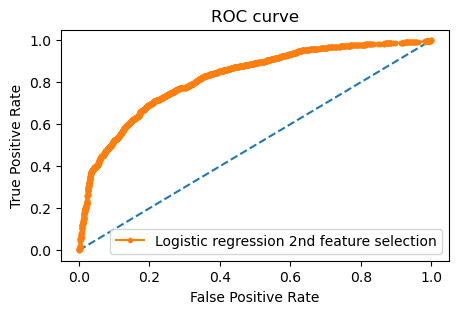

In [56]:
regLog3, X_test3, y_test3, y_pred3, scaler3 = reg_log(X_fselec2, y_down_AV)

plot_CM(y_test3, y_pred3)
plot_ROC(regLog3, X_test3, y_test3, scaler3, model_name='Logistic regression 2nd feature selection')

In [57]:
print(X_fselec2.columns)
print(regLog3.coef_[0])

Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito',
       'Sector_Cultura'],
      dtype='object')
[-0.04325953 -1.255394   -3.46810791  1.95644501  3.90311353 -0.40195825
 -0.71941369]


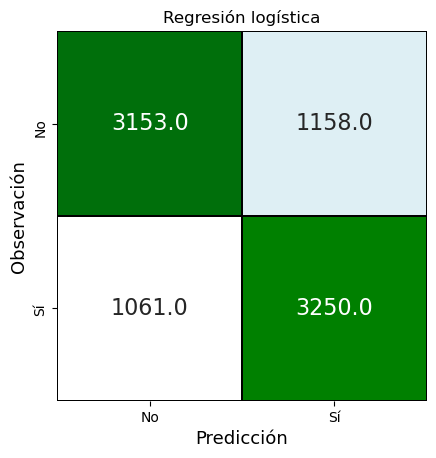

In [58]:
plot_CM(y_test3, y_pred3, plot=True, title='Regresión logística')

Note que los resultados son muy similares a los del modelo anterior, tanto para la matriz de confusión como para el AUC-ROC. Así, naturalmente, nos quedamos con el modelo más simple de los dos.

**Regresión logística con variables de la segunda selección de variables más sectores relevantes según primera selección de variables**

In [59]:
vars_sel2_psectores = ['Valor del Contrato',
                       'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
                       'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion',
                       'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible',
                       'Sector_Cultura', 'Sector_No aplica/No pertenece',
                       'Sector_Salud y Protección Social', 'Sector_Servicio Público',
                       'Sector_Transporte', 'Sector_Vivienda, Ciudad y Territorio'
                      ]

In [60]:
X_fselec2_sectores = X_fselec[vars_sel2_psectores]

Accuracy para Regresión Logística con validación cruzada: 0.7740 
El accuracy del test es: 0.7745
La sensitividad(recall) del test es: 0.7912
La precisión del test es: 0.7657
BIC: 139.75
AIC: 29.02


Predicción,No,Sí
Observación,,
No,3267,1044
Sí,900,3411


Model: ROC AUC = 0.852


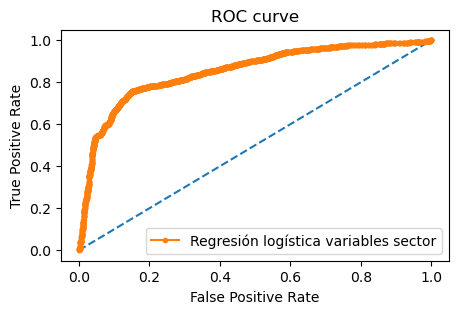

In [61]:
regLog_sec, X_test_sec, y_test_sec, y_pred_sec, scaler_sec = reg_log(X_fselec2_sectores, y_down_AV)

plot_CM(y_test_sec, y_pred_sec)
plot_ROC(regLog_sec, X_test_sec, y_test_sec, scaler_sec, model_name='Regresión logística variables sector')

### Bosque aleatorio

Ejemplificación del arbol de decisión

In [62]:
treeclf = DecisionTreeClassifier(random_state=42, max_depth=3).fit(X_fselec2, y_down_AV)

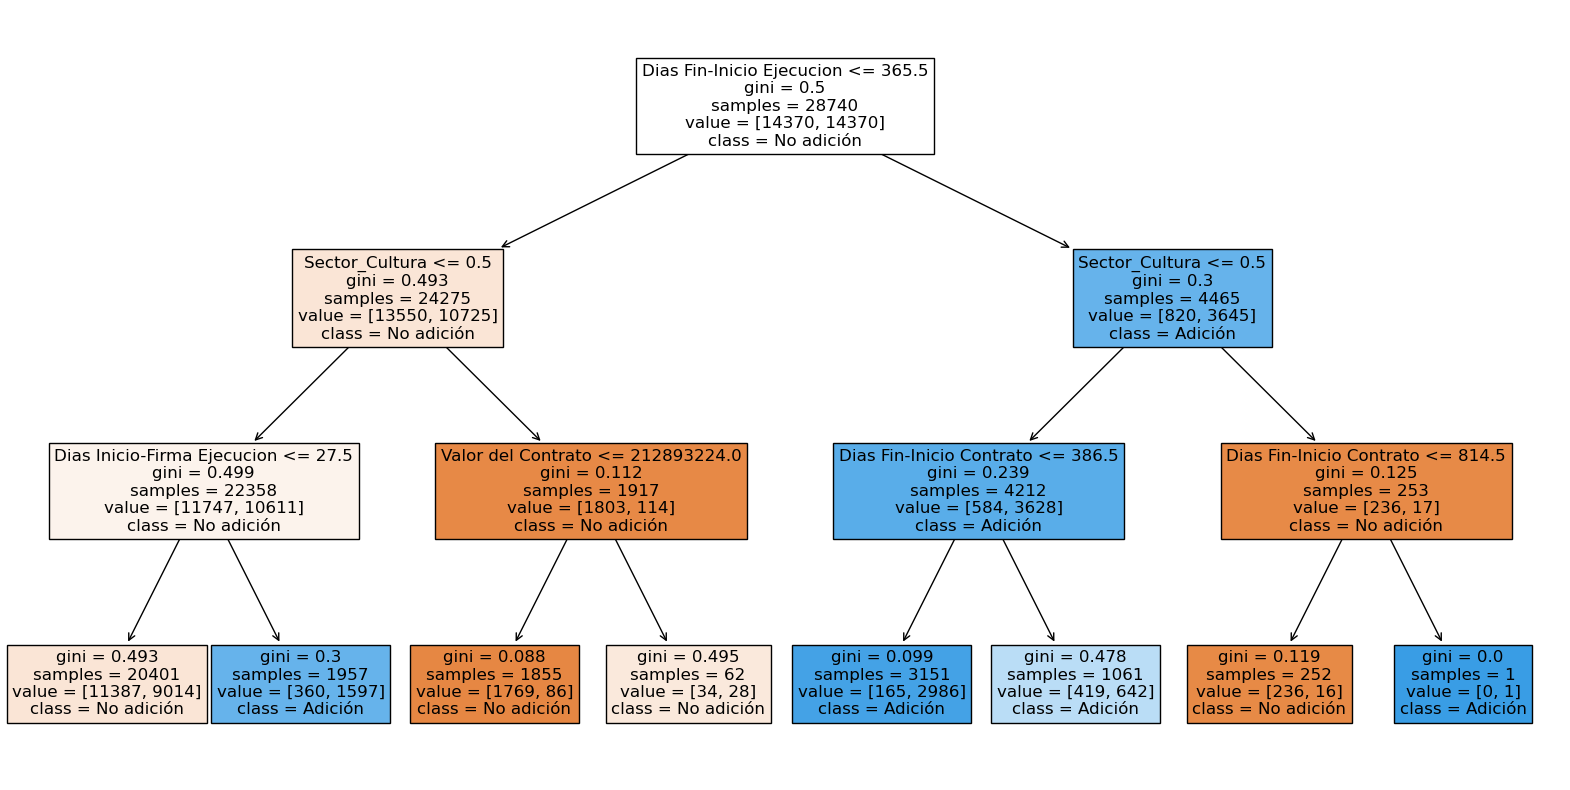

In [63]:
plt.figure(figsize=(20,10))
out = tree.plot_tree(treeclf, 
                     filled=True, 
                     feature_names=X_fselec2.columns, 
                     class_names=['No adición', 'Adición'],
                     fontsize=12
                    )
# plt.savefig('created_data/figures/mapa_ejemploarbol.png')

**Bosque aleatorio con primera elección de variables**

Accuracy del test: 0.8952
La sensitividad(recall) del test es: 0.8778
La precisión del test es: 0.9094


Predicción,No,Sí
Observación,,
No,3934,377
Sí,527,3784


Model: ROC AUC = 0.960


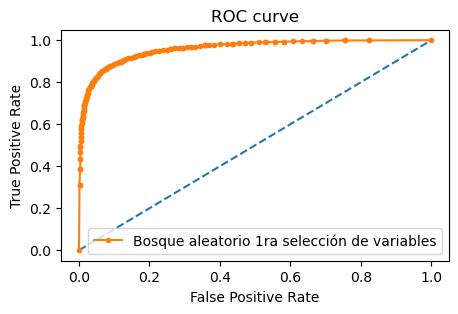

In [64]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y_down_AV)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, model_name='Bosque aleatorio 1ra selección de variables')

**Bosque aleatorio con segunda elección de variables**

Accuracy del test: 0.8747
La sensitividad(recall) del test es: 0.8492
La precisión del test es: 0.8949


Predicción,No,Sí
Observación,,
No,3881,430
Sí,650,3661


Model: ROC AUC = 0.943


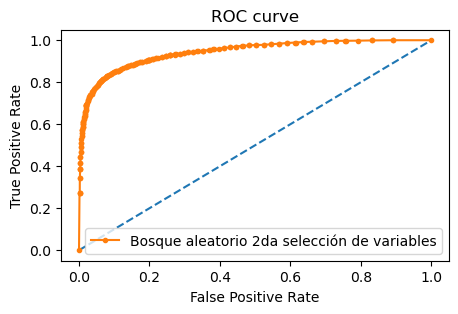

In [65]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2, X_train2, y_train2 = random_forest(X_fselec2, y_down_AV, get_train=True)

plot_CM(y_test2, y_pred_forest2),
plot_ROC(forest2, X_test2, y_test2, scaler2, model_name='Bosque aleatorio 2da selección de variables', figsize=(5,3))

**Comparar resultados de modelo con todos los datos entre tipo de contrato prestación de servicios**

In [66]:
X_test2_comp = X_down.iloc[X_test2.index]

pd.crosstab(X_test2_comp['Tipo de Contrato_Prestación de servicios'], y_test2, margins=True, normalize='index')

Tuvo_adiciones_valor,0,1
Tipo de Contrato_Prestación de servicios,,
0,0.617368,0.382632
1,0.489030,0.510970
All,0.500000,0.500000


In [67]:
(X_test2_comp[X_fselec2.columns].values == X_test2.values).all()

True

In [68]:
y_by_ps = pd.DataFrame({'True':y_test2, 'Predicted':y_pred_forest2,
                        'PS': X_test2_comp['Tipo de Contrato_Prestación de servicios']},
                       index=y_test2.index)
ps_bool_idx = y_by_ps['PS'] == 1

# Comparar medidas
ps_acc = accuracy_score(y_by_ps.loc[ps_bool_idx, 'True'], y_by_ps.loc[ps_bool_idx, 'Predicted'])
ps_rec = recall_score(y_by_ps.loc[ps_bool_idx, 'True'], y_by_ps.loc[ps_bool_idx, 'Predicted'])
print('Prestación de servicios: acc:{:.4f}, recall:{:.4f}'.format(ps_acc, ps_rec))
plot_CM(y_by_ps.loc[ps_bool_idx, 'True'], y_by_ps.loc[ps_bool_idx, 'Predicted'])

nps_acc = accuracy_score(y_by_ps.loc[~ps_bool_idx, 'True'], y_by_ps.loc[~ps_bool_idx, 'Predicted'])
nps_rec = recall_score(y_by_ps.loc[~ps_bool_idx, 'True'], y_by_ps.loc[~ps_bool_idx, 'Predicted'])
print('Diferente a prestación de servicios: acc:{:.4f}, recall:{:.4f}'.format(nps_acc, nps_rec))
plot_CM(y_by_ps.loc[~ps_bool_idx, 'True'], y_by_ps.loc[~ps_bool_idx, 'Predicted']);



Prestación de servicios: acc:0.8832, recall:0.8630


Predicción,No,Sí
Observación,,
No,3487,369
Sí,552,3477


Diferente a prestación de servicios: acc:0.7843, recall:0.6525


Predicción,No,Sí
Observación,,
No,394,61
Sí,98,184


#### Importancia de variables

In [69]:
X_train_sc = pd.DataFrame(scaler2.transform(X_train2), columns=X_train2.columns)

Wall time: 3min 3s


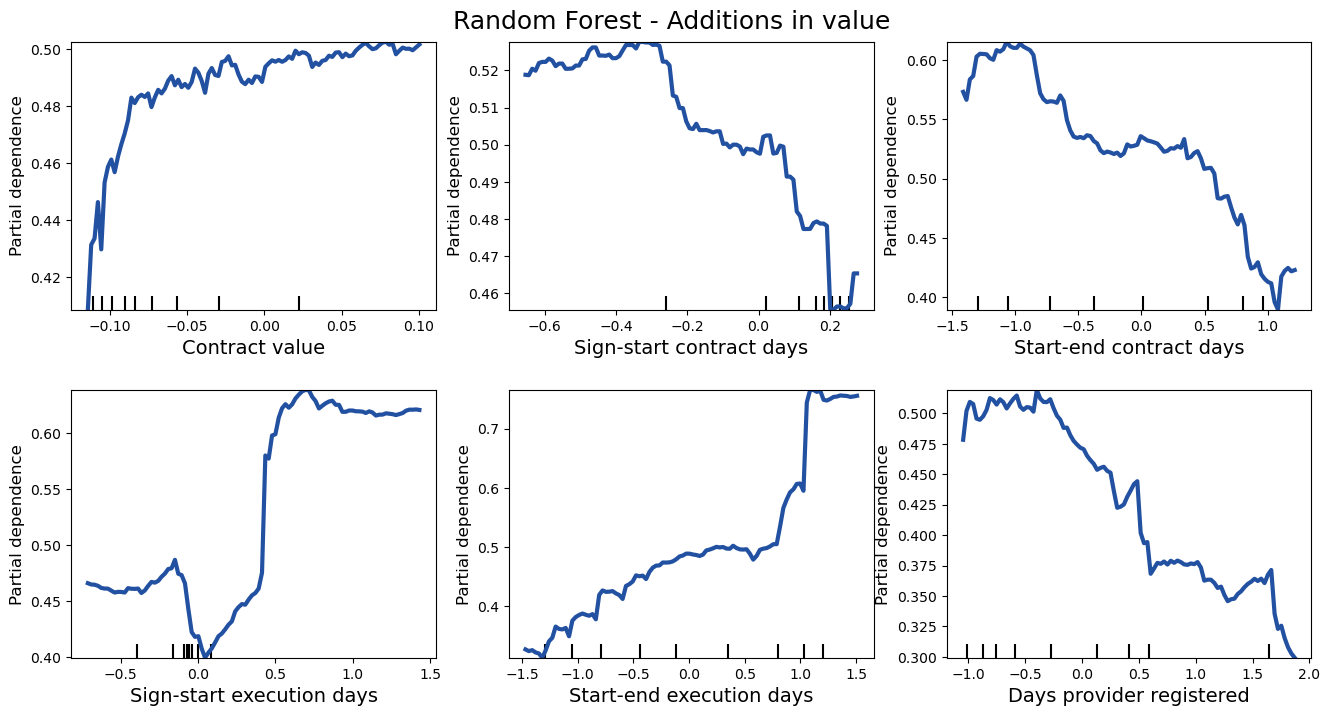

In [70]:
%%time
variables = list(X_train2.columns)
eng_vars = ['Contract value', 'Sign-start contract days', 'Start-end contract days',
           'Sign-start execution days', 'Start-end execution days',
           'Days provider registered', 'Sector (Culture)']
eng_vars = dict(zip(variables, eng_vars))

plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle('Random Forest - Additions in value', fontsize=18, y=0.92)
for n, var in enumerate(variables[:-1]): # Exclude sector -1
    ax = plt.subplot(2, 3, n+1)
    plot_partial_dependence(forest2, X_train_sc, [var],
                            ax=ax, line_kw={"color": "#2351a2", "linewidth":3})
    plt.xlabel(eng_vars[var], fontsize=14)
    plt.ylabel('Partial dependence', fontsize=12)
plt.savefig('created_data/figures/PDP_RF_AdValor.svg')

In [71]:
forest_importances = pd.Series(forest2.feature_importances_,
                               index=X_fselec2.columns)
forest_importances.sort_values(ascending=False)

Dias Fin-Inicio Ejecucion      0.232508
Dias Fin-Inicio Contrato       0.195581
Dias Proveedor Inscrito        0.178211
Valor del Contrato             0.145847
Dias Inicio-Firma Ejecucion    0.109677
Dias Inicio-Firma Contrato     0.084416
Sector_Cultura                 0.053760
dtype: float64

In [73]:
#Guardar modelo
print('Variables del modelos:',X_fselec2.columns)
filename = 'created_data/trained_models/model_secopII_AdValor_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)  #Modelo

filename_scaler = 'created_data/trained_models/scaler_secopII_AdValor_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)  #scaler

Variables del modelos: Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito',
       'Sector_Cultura'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdValor_TipoContratoTodos_rf.pkl']

In [74]:
filename = 'created_data/trained_models/model_secopII_AdValor_TipoContratoTodos_rf.pkl'
pp = joblib.load(filename)

In [75]:
del pp

Guardar variables para comparaciones posteriores

rf: Random forest, TO: Todas las observaciones, TV: Todas las Variables

In [76]:
rf_TO_TV = forest2
X_test_TO_TV, y_test_TO_TV = X_test2, y_test2
y_pred_TO_TV = y_pred_forest2
scaler_TO_TV = scaler2
X_train_TO_TV, y_train_TO_TV = X_train2, y_train2

### Bosque aleatorio vs regresión logística 
con segunda selección de variables, adiciones en valor

In [77]:
# Confirmar que los datos de test en ambos son iguales
(y_test2 == y_test3).all()

True

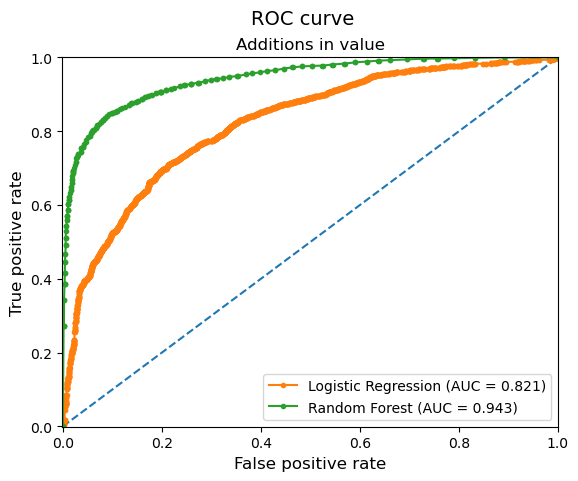

In [78]:
# Crear predicciones
ns_probs = [0 for _ in range(len(y_test2))]
lr_probs = regLog3.predict_proba(scaler3.transform(X_test2))[:, 1]
rf_probs = forest2.predict_proba(scaler2.transform(X_test2))[:, 1]

lr_auc = roc_auc_score(y_test2, lr_probs)
rf_auc = roc_auc_score(y_test2, rf_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test2, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test2, rf_probs)

#plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
plt.plot(lr_fpr, lr_tpr, marker = '.', label = 'Logistic Regression (AUC = {:1.3F})'.format(lr_auc))
plt.plot(rf_fpr, rf_tpr, marker = '.', label = 'Random Forest (AUC = {:1.3F})'.format(rf_auc))
plt.xlim([-0.001,1.001])
plt.ylim([-0.001,1.001])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right")
plt.suptitle('ROC curve', fontsize=14)
plt.title('Additions in value')

# plt.savefig('created_data/figures/ROC_AValor_muestracompleta.png')
plt.savefig('created_data/figures/ROC_AValor_muestracompleta.svg')

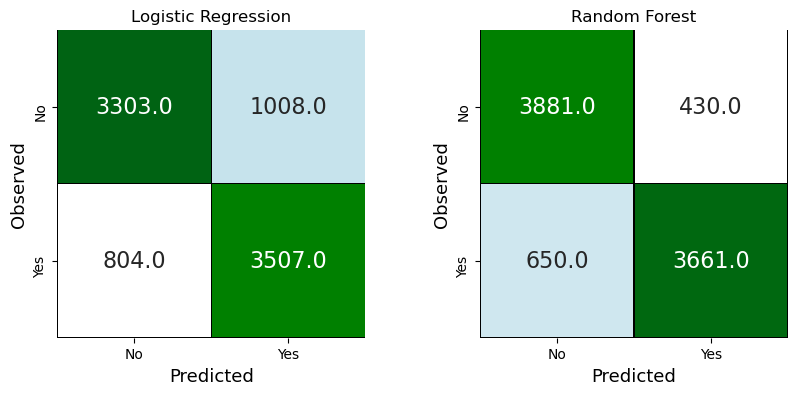

In [79]:
# plt.figure(figsize=(12,5))
# plt.subplot(121)
# plot_CM(y_test3, y_pred3, plot=True, title='Regresión logística')
# plt.subplot(122)
# plot_CM(y_test2, y_pred_forest2, plot=True, title='Bosque aleatorio')
plt.figure(figsize=(10,4))

plt.subplot(121)
cm = confusion_matrix(y_test2, y_pred2)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Logistic Regression')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

plt.subplot(122)
cm = confusion_matrix(y_test2, y_pred_forest2)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Random Forest')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

# plt.savefig('created_data/figures/MatConf_AValor_muestracompleta.png')
plt.savefig('created_data/figures/MatConf_AValor_muestracompleta.svg')

### Excluir variables de ejecución.
Y tiempos pactados en el contrato

In [81]:
#Eliminar variables de ejecución y días
X_down = X_down.drop(columns=vars_ejecucion)

Selección de variables

In [82]:
X_fselec = feature_selection(X_down, y_down_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Transporte', 'Sector_Vivienda, Ciudad y Territorio', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Destino Gasto_No Definido', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Abr', 'Mes de Publicacio

In [83]:
X_fselec.shape

(28740, 30)

In [84]:
X_fselec2 = feature_selection(X_fselec, y_down_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Cultura']


In [85]:
X_fselec3 = feature_selection(X_fselec, y_down_AV, threshold="1.3*median")

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)']


Bosque aleatorio

Accuracy del test: 0.8138
La sensitividad(recall) del test es: 0.8109
La precisión del test es: 0.8157


Predicción,No,Sí
Observación,,
No,3521,790
Sí,815,3496


Model: ROC AUC = 0.901


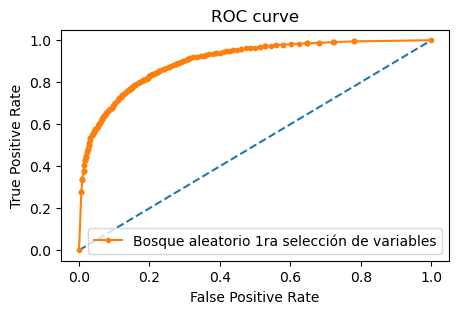

In [86]:
#Primera selección de variables
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y_down_AV)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, model_name='Bosque aleatorio 1ra selección de variables')

Segunda selección de variables

Accuracy del test: 0.6996
La sensitividad(recall) del test es: 0.6989
La precisión del test es: 0.6999


Predicción,No,Sí
Observación,,
No,3019,1292
Sí,1298,3013


Model: ROC AUC = 0.789


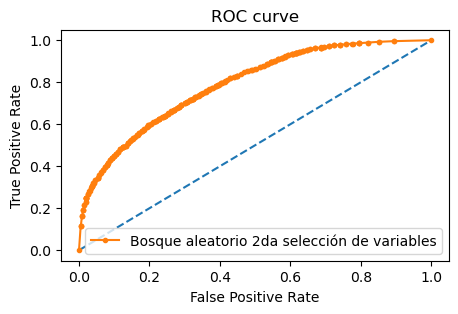

In [87]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2, X_train2, y_train2 = random_forest(X_fselec2, y_down_AV, get_train = True)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, model_name='Bosque aleatorio 2da selección de variables')

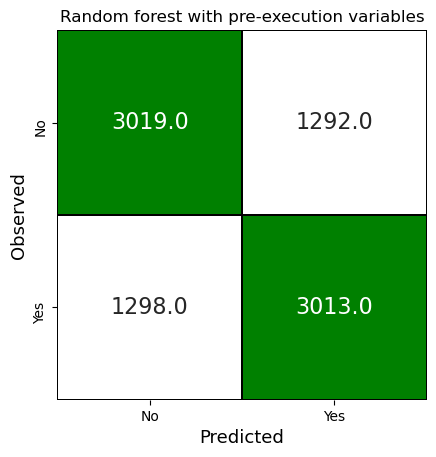

In [88]:
plt.figure()
plot_CM(y_test2, y_pred_forest2, plot=True, title='Random forest with pre-execution variables',
       xlabel='Predicted', ylabel='Observed', tickslabel=['No','Yes'],
        savedir='created_data/figures/MatConf_AValor_preejecucion.svg')

#### Modelo ajuste umbral selección

Accuracy del test: 0.7606
La sensitividad(recall) del test es: 0.7620
La precisión del test es: 0.7599


Predicción,No,Sí
Observación,,
No,3273,1038
Sí,1026,3285


Model: ROC AUC = 0.850


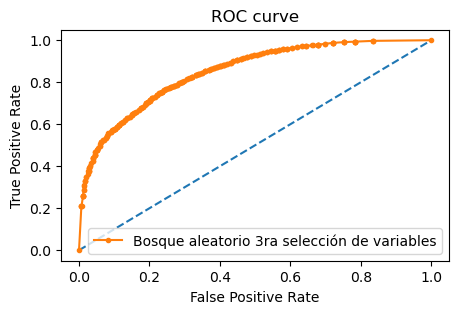

In [89]:
forest3, X_test3, y_test3, y_pred_forest3, scaler3, X_train3, y_train3 = random_forest(X_fselec3, y_down_AV, get_train = True)

plot_CM(y_test3, y_pred_forest3)
plot_ROC(forest3, X_test3, y_test3, scaler3, model_name='Bosque aleatorio 3ra selección de variables')

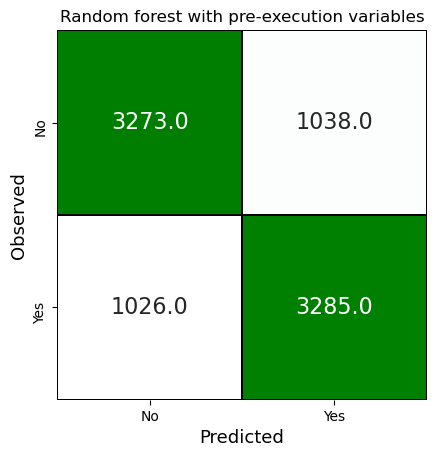

In [90]:
plt.figure()
plot_CM(y_test3, y_pred_forest3, plot=True, title='Random forest with pre-execution variables',
       xlabel='Predicted', ylabel='Observed', tickslabel=['No','Yes'],
        savedir='created_data/figures/MatConf_AValor_preejecucion_b.svg')

Guardar modelo

In [91]:
#Guardar modelo
print('Variables del modelos:',X_fselec2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdValor_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)  #Modelo

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)  #scaler

Variables del modelos: Index(['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Cultura'], dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoTodos_rf.pkl']

Guardar variables para comparaciones posteriores

rf: Random forest, TO: Todas las observaciones, VPE: Variables prejecución

In [92]:
rf_TO_VPE = forest3
X_test_TO_VPE, y_test_TO_VPE = X_test3, y_test3
y_pred_TO_VPE = y_pred_forest3
scaler_TO_VPE = scaler3

### Comparación todas variables vs preejecución
Con segunda elección de variables y todas las observaciones (sin distinguir por tipo de contrato)

In [93]:
rf_TO_TV
X_test_TO_TV, y_test_TO_TV
y_pred_TO_TV
scaler_TO_TV

StandardScaler()

In [94]:
(y_test_TO_TV == y_test_TO_VPE).all()

True

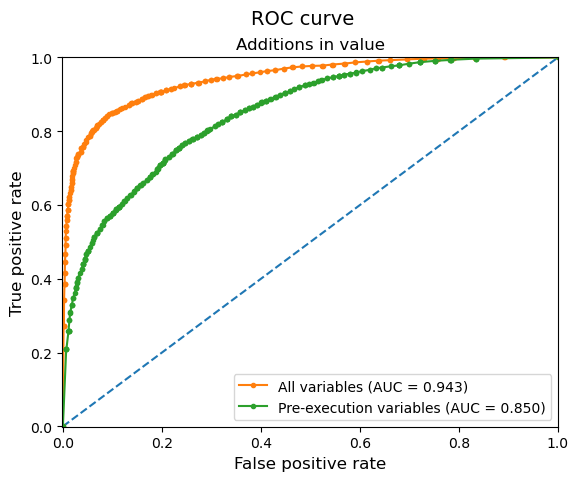

In [95]:
# Crear predicciones
ns_probs = [0 for _ in range(len(y_test_TO_TV))]
TV_probs = rf_TO_TV.predict_proba(scaler_TO_TV.transform(X_test_TO_TV))[:, 1]
VPE_probs = rf_TO_VPE.predict_proba(scaler_TO_VPE.transform(X_test_TO_VPE))[:, 1]

TV_auc = roc_auc_score(y_test_TO_TV, TV_probs)
VPE_auc = roc_auc_score(y_test_TO_VPE, VPE_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test_TO_TV, ns_probs)
TV_fpr, TV_tpr, _ = roc_curve(y_test_TO_TV, TV_probs)
VPE_fpr, VPE_tpr, _ = roc_curve(y_test_TO_VPE, VPE_probs)

#plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
plt.plot(TV_fpr, TV_tpr, marker = '.', label = 'All variables (AUC = {:1.3F})'.format(TV_auc))
plt.plot(VPE_fpr, VPE_tpr, marker = '.', label = 'Pre-execution variables (AUC = {:1.3F})'.format(VPE_auc))
plt.xlim([-0.001,1.001])
plt.ylim([-0.001,1.001])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right")
plt.suptitle('ROC curve', fontsize=14)
plt.title('Additions in value')

plt.savefig('created_data/figures/ROC_AValor_todasvariables_vs_preejecucion_b.svg')

## Modelos para contratos de prestación de servicios
Se filtran las observaciones por la variable `Tipo de Contrato` conservando aquellos del tipo "Prestación de servicios".

In [96]:
df_downsampled_AV["Tipo de Contrato"].value_counts()

Prestación de servicios       26358
Decreto 092 de 2017             898
Otro                            414
Suministros                     325
Compraventa                     285
Interventoría                   144
Obra                            124
Consultoría                      72
Seguros                          64
Arrendamiento de inmuebles       56
Name: Tipo de Contrato, dtype: int64

In [97]:
X_prestacion = df_downsampled_AV[df_downsampled_AV["Tipo de Contrato"] == "Prestación de servicios"]
y_prestacion_AV = X_prestacion["Tuvo_adiciones_valor"]

X_prestacion = X_prestacion.drop(columns = vars_a_excluir+["Tipo de Contrato"])
X_prestacion = pd.get_dummies(data = X_prestacion, columns = vars_categoricas)

In [98]:
y_prestacion_AV.value_counts(normalize=True)

1    0.508574
0    0.491426
Name: Tuvo_adiciones_valor, dtype: float64

No hay problema con el balanceo

### Selección de variables

Se realiza el proceso de selección de variables mediante bosque aleatorio con la submuestra de contratos del tipo prestación de servicios. Esto debido a que al revisar las correlaciones se vio que pueden existir un conjunto de relaciones diferentes los presentados con todos los datos.

In [99]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Vivienda, Ciudad y Territorio', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Liquidación_No', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Me

Se repite el procedimiento de selección de variables.

In [100]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Cultura']


### Regresión logística

Modelo con primera selección de variables

Accuracy para Regresión Logística con validación cruzada: 0.7990 
El accuracy del test es: 0.7949
La sensitividad(recall) del test es: 0.8173
La precisión del test es: 0.7875
BIC: 325.07
AIC: 66.92


Predicción,No,Sí
Observación,,
No,2999,887
Sí,735,3287


Model: ROC AUC = 0.885


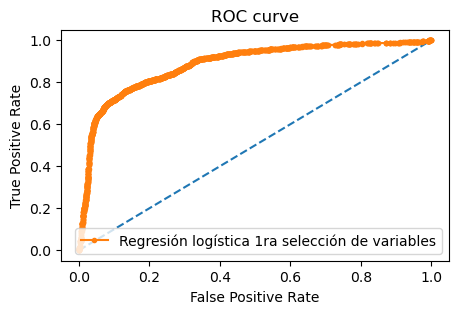

In [101]:
regLog_prest, X_test_prest, y_test_prest, y_pred_prest, scaler_prest = reg_log(X_fselec_Pservicios, y_prestacion_AV)

plot_CM(y_test_prest, y_pred_prest)
plot_ROC(regLog_prest, X_test_prest, y_test_prest, scaler_prest, 
         model_name='Regresión logística 1ra selección de variables')

Modelo con primera selección de variables

Accuracy para Regresión Logística con validación cruzada: 0.7567 
El accuracy del test es: 0.7614
La sensitividad(recall) del test es: 0.7618
La precisión del test es: 0.7673
BIC: 79.64
AIC: 17.06


Predicción,No,Sí
Observación,,
No,2957,929
Sí,958,3064


Predicción,No,Sí
Observación,,
No,2957,929
Sí,958,3064


Model: ROC AUC = 0.845


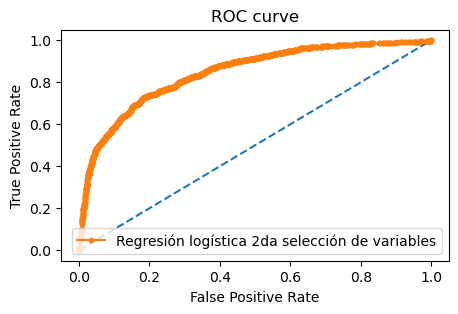

In [102]:
regLog_prest2, X_test_prest2, y_test_prest2, y_pred_prest2, scaler_prest2 = reg_log(X_fselec_Pservicios2, y_prestacion_AV)

display(plot_CM(y_test_prest2, y_pred_prest2))
plot_ROC(regLog_prest2, X_test_prest2, y_test_prest2, scaler_prest2, 
         model_name='Regresión logística 2da selección de variables')

### Bosque aleatorio

Modelo con el primer conjunto de variables seleccionadas.

Accuracy del test: 0.9005
La sensitividad(recall) del test es: 0.8846
La precisión del test es: 0.9168


Predicción,No,Sí
Observación,,
No,3563,323
Sí,464,3558


Model: ROC AUC = 0.962


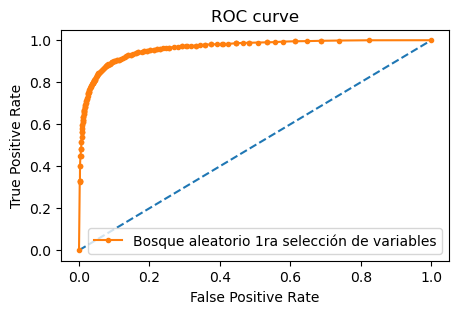

In [103]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_AV)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

Modelo con el segundo conjunto de variables seleccionadas.

Accuracy del test: 0.8829
La sensitividad(recall) del test es: 0.8615
La precisión del test es: 0.9038


Predicción,No,Sí
Observación,,
No,3517,369
Sí,557,3465


Model: ROC AUC = 0.948


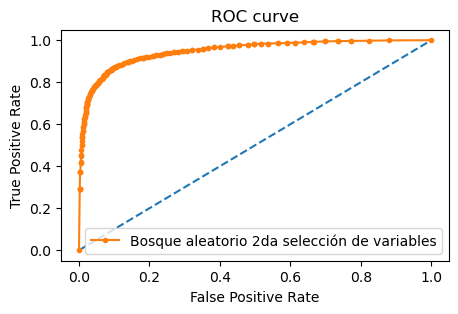

In [104]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_AV)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

Guardar variables para comparaciones posteriores

rf: Random forest, PS: Prestación de servicios, TV: Todas las Variables

In [105]:
rf_PS_TV = forest2
X_test_PS_TV, y_test_PS_TV = X_test2, y_test2
y_pred_PS_TV = y_pred_forest2
scaler_PS_TV = scaler2

In [106]:
#Guardar modelo
print('Variables del modelos:',X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/model_secopII_AdValor_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_AdValor_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelos: Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito',
       'Sector_Cultura'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdValor_TipoContratoPreServicios_rf.pkl']

### Excluir variables de ejecución.
Y tiempos pactados en el contrato

In [107]:
X_prestacion = X_prestacion.drop(columns=vars_ejecucion)

Selección de variables

In [108]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Transporte', 'Sector_Vivienda, Ciudad y Territorio', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Abr', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion de

In [109]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Cultura']


Bosque aleatorio

Accuracy del test: 0.8238
La sensitividad(recall) del test es: 0.8294
La precisión del test es: 0.8251


Predicción,No,Sí
Observación,,
No,3179,707
Sí,686,3336


Model: ROC AUC = 0.906


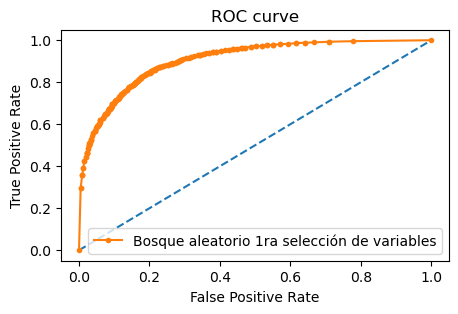

In [110]:
#Primera selección de variables
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_AV)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

Accuracy del test: 0.7073
La sensitividad(recall) del test es: 0.7277
La precisión del test es: 0.7058


Predicción,No,Sí
Observación,,
No,2666,1220
Sí,1095,2927


Model: ROC AUC = 0.794


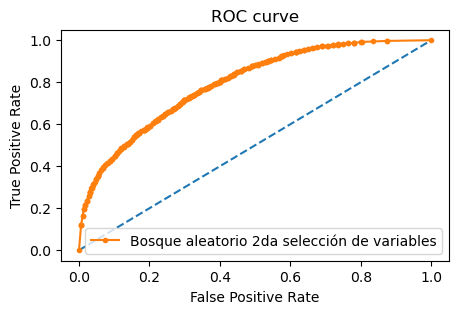

In [111]:
#Segunda selección de variables
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_AV)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

Guardar modelos

In [112]:
#Guardar modelo
print('Variables del modelos:',X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdValor_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelos: Index(['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Cultura'], dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoPreServicios_rf.pkl']

In [113]:
rf_PS_TV
X_test_PS_TV, y_test_PS_TV
y_pred_PS_TV
scaler_PS_TV

StandardScaler()

## Modelos para contratos diferentes a prestación de servicios

Debido al bajo número de contratos diferentes a prestación de servicios no es idoneo balancear los datos por medio de downsampling.

In [115]:
df_downsampled_AV['Tipo de Contrato'].value_counts()

Prestación de servicios       26358
Decreto 092 de 2017             898
Otro                            414
Suministros                     325
Compraventa                     285
Interventoría                   144
Obra                            124
Consultoría                      72
Seguros                          64
Arrendamiento de inmuebles       56
Name: Tipo de Contrato, dtype: int64

In [116]:
df_NOprestacion_comp = df_downsampled_AV[df_downsampled_AV["Tipo de Contrato"] != "Prestación de servicios"]
y_NOprestacion_AV = df_NOprestacion_comp["Tuvo_adiciones_valor"]

X_NOprestacion = df_NOprestacion_comp.drop(columns = vars_a_excluir+["Tipo de Contrato"]).copy()
X_NOprestacion = pd.get_dummies(data = X_NOprestacion, columns = vars_categoricas)

In [117]:
X_NOprestacion.shape

(2382, 188)

In [118]:
y_NOprestacion_AV.value_counts(normalize=True)

0    0.594878
1    0.405122
Name: Tuvo_adiciones_valor, dtype: float64

Nuevo balanceo por downsampling

In [119]:
df_NOprest_downsampled_AV = balance(df_NOprestacion_comp, "Tuvo_adiciones_valor")
y_NOprest_downsampled_AV = df_NOprest_downsampled_AV["Tuvo_adiciones_valor"]

X_NOprest_downsampled_AV = df_NOprest_downsampled_AV.drop(columns = vars_a_excluir+["Tipo de Contrato"]).copy()
X_NOprest_downsampled_AV = pd.get_dummies(data = X_NOprest_downsampled_AV, columns = vars_categoricas)

In [120]:
y_NOprest_downsampled_AV.value_counts()

0    965
1    965
Name: Tuvo_adiciones_valor, dtype: int64

In [121]:
X_NOprest_downsampled_AV.shape

(1930, 186)

Al ser menos observaciones hay registros de variables que se pierden, por tanto menos variables dummies.

### Selección de variables

In [122]:
X_fselec_NOprestacion = feature_selection(X_NOprestacion, y_NOprestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Cultura', 'Sector_Ley de Justicia', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación Directa (con ofertas)', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_No existe pluralidad de oferentes en el mercado', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Liquidación_No', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Dic'

In [123]:
X_fselec_NOprestacion2 = feature_selection(X_fselec_NOprestacion, y_NOprestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Grupo categoria principal_Servicios administrativos']


In [124]:
X_fselec_NOprestacion2.shape

(2382, 9)

Selección de variables con nuevo downsampling.

En adelante en los nombres de variables downsampled = downs

In [125]:
X_fselec_NOprest_downs = feature_selection(X_NOprest_downsampled_AV, y_NOprest_downsampled_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Numero_de_procesos_reportados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_No existe pluralidad de oferentes en el mercado', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Liquidación_No', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Dic', 'Mes Firma Contrato_Mar', 'Mes Firma Contrato_Sep', 'Grupo categoria principal_Productos manufacturados', 'Grupo 

In [126]:
X_fselec_NOprest_downs2 = feature_selection(X_fselec_NOprest_downs, y_NOprest_downsampled_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Grupo categoria principal_Servicios administrativos', 'Codigo Segmento Categoria Principal_80000000', 'Codigo Segmento Categoria Principal_85000000']


### Regresión logística

Regresión logística con todas las variables de la muestra.

Accuracy para Regresión Logística con validación cruzada: 0.7223 
El accuracy del test es: 0.7245
La sensitividad(recall) del test es: 0.7034
La precisión del test es: 0.6476
BIC: 1403.02
AIC: 378.87


Predicción,No,Sí
Observación,,
No,314,111
Sí,86,204


Model: ROC AUC = 0.802


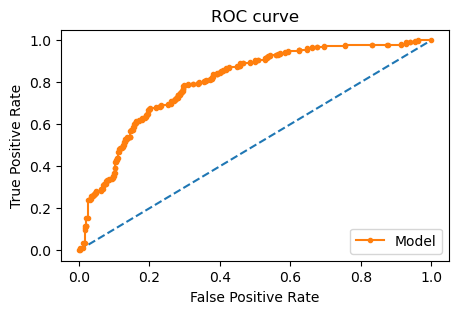

In [127]:
regLog_noserv, X_test_noserv, y_test_noserv, y_pred_noserv, scaler_noserv = reg_log(X_NOprestacion, y_NOprestacion_AV)

plot_CM(y_test_noserv, y_pred_noserv)
plot_ROC(regLog_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

70,34% de contratos con adiciones bien clasificados

Modelo con la segunda selección de variables

A continuación de muestra que respecto al anterior mantiene el accuracy pero cae notoriamente la sensitividad.

Accuracy para Regresión Logística con validación cruzada: 0.7049 
El accuracy del test es: 0.7259
La sensitividad(recall) del test es: 0.6552
La precisión del test es: 0.6643
BIC: 75.34
AIC: 21.16


Predicción,No,Sí
Observación,,
No,329,96
Sí,100,190


Model: ROC AUC = 0.768


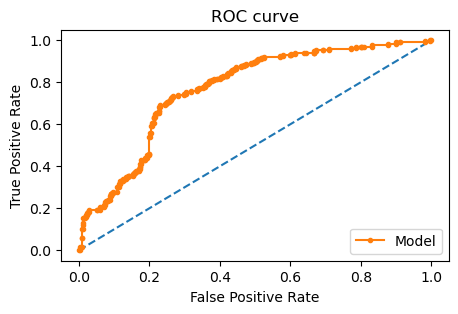

In [128]:
regLog_noserv2, X_test_noserv2, y_test_noserv2, y_pred_noserv2, scaler_noserv2 = reg_log(X_fselec_NOprestacion2, 
                                                                                         y_NOprestacion_AV)

plot_CM(y_test_noserv2, y_pred_noserv2)
plot_ROC(regLog_noserv2, X_test_noserv2, y_test_noserv2, scaler_noserv2)

### Bosques aleatorios

Usando solo las variables significativas de la segunda selección de variables se encuentra que todavía hay margen de mejora.

Accuracy del test: 0.7916
La sensitividad(recall) del test es: 0.7034
La precisión del test es: 0.7640


Predicción,No,Sí
Observación,,
No,362,63
Sí,86,204


Model: ROC AUC = 0.872


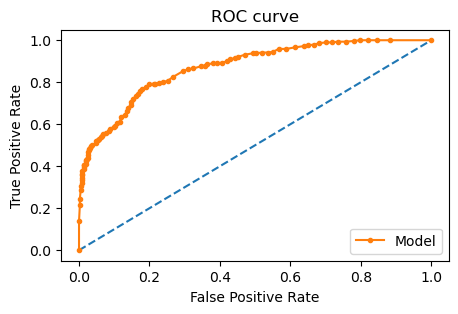

In [129]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion2, 
                                                                                                 y_NOprestacion_AV)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

Guardar variables para comparaciones posteriores

rf: Random forest, NoPS: Diferente de Prestación de servicios, TV: Todas las Variables

In [130]:
rf_NoPS_TV = forest_noserv
X_test_NoPS_TV, y_test_NoPS_TV = X_test_noserv, y_test_noserv
y_pred_NoPS_TV = y_pred_forest_noserv
scaler_NoPS_TV = scaler_noserv

In [131]:
#Guardar modelo
print('Variables del modelo:',X_fselec_NOprestacion2.columns)
filename = 'created_data/trained_models/model_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
       'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion',
       'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto',
       'Grupo categoria principal_Servicios administrativos'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl']

Bosque aleatorio vs regresión logística con segunda selección de variables.

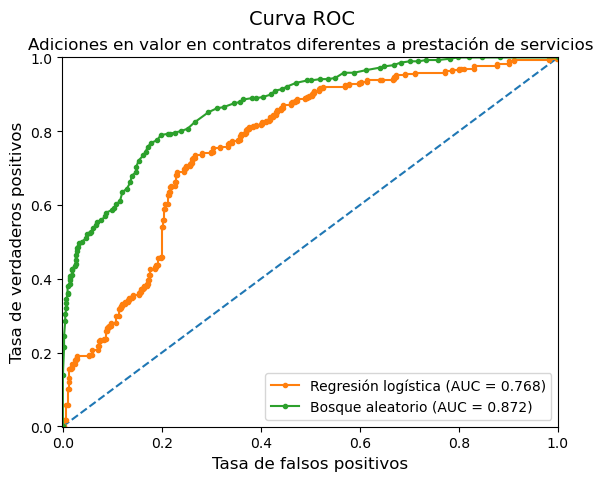

In [132]:
# Crear predicciones
ns_probs = [0 for _ in range(len(y_test_noserv))]
lr_probs = regLog_noserv2.predict_proba(scaler_noserv.transform(X_test_noserv))[:, 1]
rf_probs = forest_noserv.predict_proba(scaler_noserv.transform(X_test_noserv))[:, 1]

lr_auc = roc_auc_score(y_test_noserv, lr_probs)
rf_auc = roc_auc_score(y_test_noserv, rf_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test_noserv, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_noserv, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_noserv, rf_probs)

#plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
plt.plot(lr_fpr, lr_tpr, marker = '.', label = 'Regresión logística (AUC = {:1.3F})'.format(lr_auc))
plt.plot(rf_fpr, rf_tpr, marker = '.', label = 'Bosque aleatorio (AUC = {:1.3F})'.format(rf_auc))
plt.xlim([-0.001,1.001])
plt.ylim([-0.001,1.001])
plt.xlabel('Tasa de falsos positivos', fontsize=12)
plt.ylabel('Tasa de verdaderos positivos', fontsize=12)
plt.legend(loc="lower right")
plt.suptitle('Curva ROC', fontsize=14)
plt.title('Adiciones en valor en contratos diferentes a prestación de servicios')

plt.savefig('created_data/figures/ROC_AValor_SinPrestacionServicios.png')

Bosque aleatorio con segunda selección de variables **y nuevo balanceo**

Accuracy del test: 0.7876
La sensitividad(recall) del test es: 0.7405
La precisión del test es: 0.8168


Predicción,No,Sí
Observación,,
No,242,48
Sí,75,214


Model: ROC AUC = 0.883


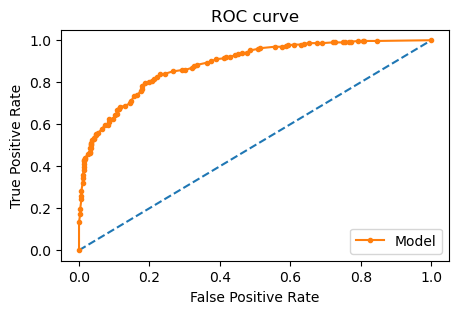

In [133]:
[fo_noserv_downs, X_test_noserv_downs, y_test_noserv_downs,
        y_pred_fo_noserv_downs, scaler_noserv_downs] = random_forest(X_fselec_NOprest_downs2, 
                                                                    y_NOprest_downsampled_AV)

plot_CM(y_test_noserv_downs, y_pred_fo_noserv_downs)
plot_ROC(fo_noserv_downs, X_test_noserv_downs, y_test_noserv_downs, scaler_noserv_downs)

### Excluir variables de ejecución

In [134]:
X_NOprestacion = X_NOprestacion.drop(columns=vars_ejecucion)

Selección de variables

In [135]:
X_fselec_NOprestacion = feature_selection(X_NOprestacion, y_NOprestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Numero_de_procesos_reportados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Cultura', 'Sector_Ley de Justicia', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación Directa (con ofertas)', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_No existe pluralidad de oferentes en el mercado', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Dic', 'Mes Firma Contrato_Mar', 'Mes Fir

In [136]:
X_fselec_NOprestacion2 = feature_selection(X_fselec_NOprestacion, y_NOprestacion_AV)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Grupo categoria principal_Servicios administrativos', 'Codigo Segmento Categoria Principal_85000000']


Bosque aleatorio

Accuracy del test: 0.7049
La sensitividad(recall) del test es: 0.6345
La precisión del test es: 0.6367


Predicción,No,Sí
Observación,,
No,320,105
Sí,106,184


Model: ROC AUC = 0.793


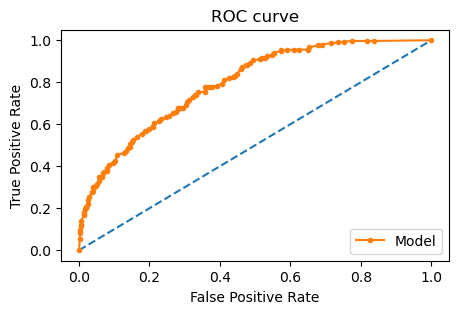

In [137]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion2, 
                                                                                                 y_NOprestacion_AV)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

Guardar modelo

In [138]:
#Guardar modelo
print('Variables del modelo:',X_fselec_NOprestacion2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto',
       'Grupo categoria principal_Servicios administrativos',
       'Codigo Segmento Categoria Principal_85000000'],
      dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdValor_TipoContratoNOPreServicios_rf.pkl']

## Comparación modelos todas observaciones vs Prestación de servicios vs No Prestación de servicios

In [139]:
rf_NoPS_TV
X_test_NoPS_TV, y_test_NoPS_TV
y_pred_NoPS_TV
scaler_NoPS_TV

StandardScaler()

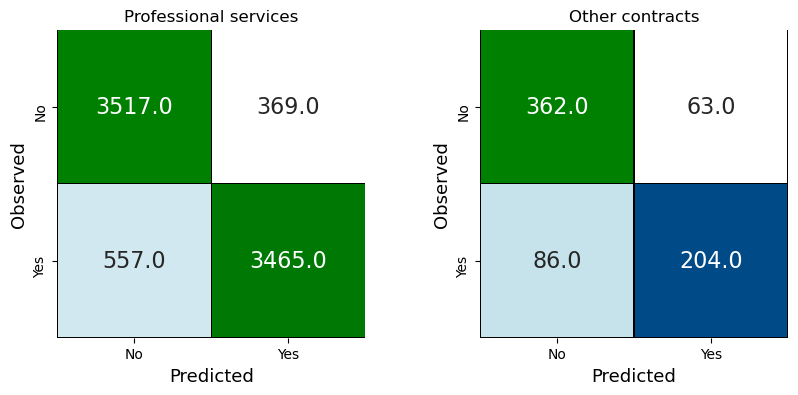

In [140]:
plt.figure(figsize=(10,4))

# Prestación de servicios
plt.subplot(121)
cm = confusion_matrix(y_test_PS_TV, y_pred_PS_TV)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Professional services')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

# ¡NO! Prestación de servicios
plt.subplot(122)
cm = confusion_matrix(y_test_NoPS_TV, y_pred_NoPS_TV)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Other contracts')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

plt.savefig('created_data/figures/MatConf_AValor_PS_vs_NoPS.svg')

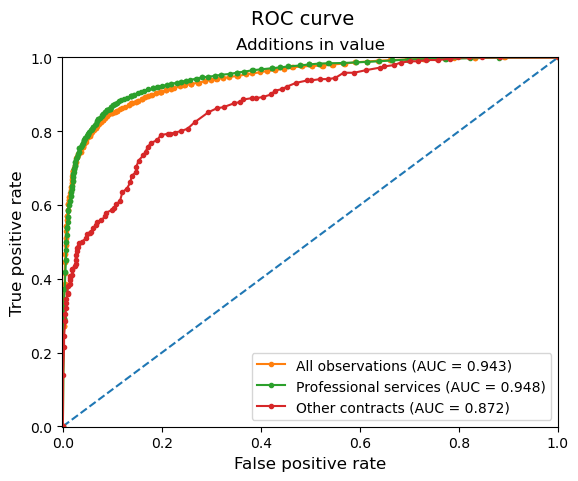

In [141]:
# Crear predicciones
ns_probs = [0 for _ in range(len(y_test_TO_TV))]
TO_probs = rf_TO_TV.predict_proba(scaler_TO_TV.transform(X_test_TO_TV))[:, 1]
PS_probs = rf_PS_TV.predict_proba(scaler_PS_TV.transform(X_test_PS_TV))[:, 1]
NoPS_probs = rf_NoPS_TV.predict_proba(scaler_NoPS_TV.transform(X_test_NoPS_TV))[:, 1]

TO_auc = roc_auc_score(y_test_TO_TV, TO_probs)
PS_auc = roc_auc_score(y_test_PS_TV, PS_probs)
NoPS_auc = roc_auc_score(y_test_NoPS_TV, NoPS_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test_TO_TV, ns_probs)
TO_fpr, TO_tpr, _ = roc_curve(y_test_TO_TV, TO_probs)
PS_fpr, PS_tpr, _ = roc_curve(y_test_PS_TV, PS_probs)
NoPS_fpr, NoPS_tpr, _ = roc_curve(y_test_NoPS_TV, NoPS_probs)

#plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
plt.plot(TO_fpr, TO_tpr, marker = '.', label = 'All observations (AUC = {:1.3F})'.format(TO_auc))
plt.plot(PS_fpr, PS_tpr, marker = '.', label = 'Professional services (AUC = {:1.3F})'.format(PS_auc))
plt.plot(NoPS_fpr, NoPS_tpr, marker = '.', label = 'Other contracts (AUC = {:1.3F})'.format(NoPS_auc))
plt.xlim([-0.001,1.001])
plt.ylim([-0.001,1.001])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right")
plt.suptitle('ROC curve', fontsize=14)
plt.title('Additions in value')

plt.savefig('created_data/figures/ROC_AValor_PS_vs_NoPS_VS_All.svg')

# `Tuvo_adiciones_tiempo` como variable respuesta

In [142]:
#El termino "_AT" al final se refiere a Adiciones en Tiempo
df_downsampled_AT = balance(base, "Tuvo_adiciones_tiempo")

X_down = pd.get_dummies(data = df_downsampled_AT, columns =  vars_categoricas+["Tipo de Contrato"])
X_down = X_down.drop(columns = vars_a_excluir)

y2_down_AT = df_downsampled_AT["Tuvo_adiciones_tiempo"]

In [143]:
df_downsampled_AT.shape

(31286, 41)

## Modelos sin diferenciar tipo de contrato

### Selección de variables

In [144]:
X_fselec = feature_selection(X_down, y2_down_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Jul', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion del Proceso_Mar', 'Codigo Segmento Categoria Principal_70000000', 'C

In [145]:
X_fselec2 = feature_selection(X_fselec, y2_down_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']


### Bosque aleatorio

**Modelo con variables de la primera selección.**

Accuracy del test: 0.9023
La sensitividad(recall) del test es: 0.9077
La precisión del test es: 0.8980


Predicción,No,Sí
Observación,,
No,4209,484
Sí,433,4260


Model: ROC AUC = 0.964


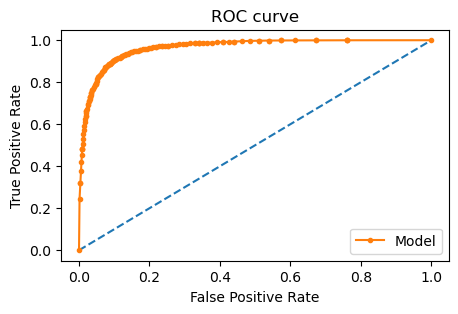

In [146]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y2_down_AT)
plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler)

**Modelo con variables de la segunda selección.**

Accuracy del test: 0.8593
La sensitividad(recall) del test es: 0.8675
La precisión del test es: 0.8535


Predicción,No,Sí
Observación,,
No,3994,699
Sí,622,4071


Model: ROC AUC = 0.936


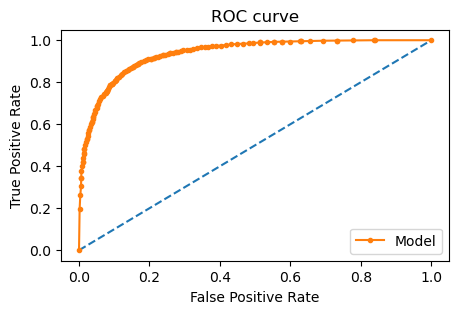

In [147]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec2, y2_down_AT)
plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2)

In [148]:
#Guardar modelo
print('Variables del modelo', X_fselec2.columns)
filename = 'created_data/trained_models/model_secopII_AdTiempo_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_AdTiempo_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdTiempo_TipoContratoTodos_rf.pkl']

### Excluir variables de ejecución

In [149]:
X_down = X_down.drop(columns=vars_ejecucion)

Selección de variables

In [150]:
X_fselec.shape

(31286, 30)

In [151]:
X_fselec = feature_selection(X_down, y2_down_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Vivienda, Ciudad y Territorio', 'Sector_defensa', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Es Pyme_No', 'Es Pyme_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion del Proceso_Mar', 'Codigo Segmento Categoria Principal_70000000', 'Codigo Segmento Categoria Principal_85000000', 'Tipo de Contrato_Dec

In [152]:
X_fselec2 = feature_selection(X_fselec, y2_down_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Mes Firma Contrato_Feb']


Bosque aleatorio

Accuracy del test: 0.8035
La sensitividad(recall) del test es: 0.8140
La precisión del test es: 0.7973


Predicción,No,Sí
Observación,,
No,3722,971
Sí,873,3820


Model: ROC AUC = 0.889


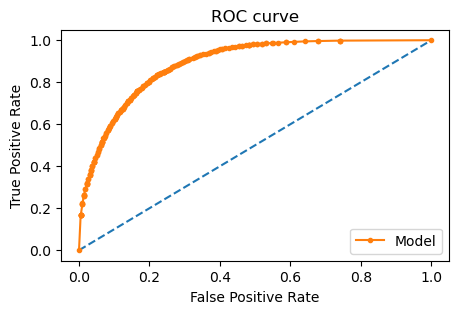

In [153]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y2_down_AT)
plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler)

Accuracy del test: 0.7004
La sensitividad(recall) del test es: 0.7027
La precisión del test es: 0.6995


Predicción,No,Sí
Observación,,
No,3276,1417
Sí,1395,3298


Model: ROC AUC = 0.779


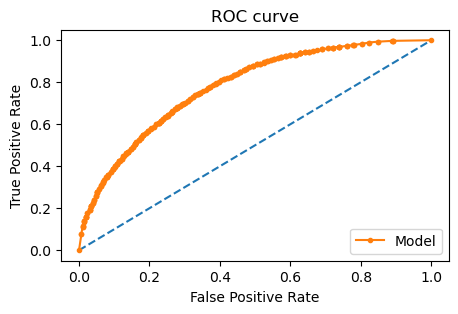

In [154]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec2, y2_down_AT)
plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2)

Guardar modelo

In [155]:
#Guardar modelo
print('Variables del modelo', X_fselec2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdTiempo_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo Index(['Valor del Contrato', 'Dias Proveedor Inscrito',
       'Mes Firma Contrato_Feb'],
      dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoTodos_rf.pkl']

## Modelos para contratos de prestación de servicios
Se filtran las observaciones por la variable `Tipo de Contrato` conservando aquellos del tipo "Prestación de servicios".

In [156]:
X_prestacion = df_downsampled_AT[df_downsampled_AT["Tipo de Contrato"] == "Prestación de servicios"]
y_prestacion_AT = X_prestacion["Tuvo_adiciones_tiempo"]

X_prestacion = X_prestacion.drop(columns = vars_a_excluir+["Tipo de Contrato"])
X_prestacion = pd.get_dummies(data = X_prestacion, columns = vars_categoricas)

### Selección de variables

In [157]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion del Proceso_Mar']


In [158]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']


### Bosque aleatorio

**Modelo con variables de la primera selección.**

Accuracy del test: 0.9023
La sensitividad(recall) del test es: 0.9039
La precisión del test es: 0.8964


Predicción,No,Sí
Observación,,
No,3872,426
Sí,392,3686


Model: ROC AUC = 0.964


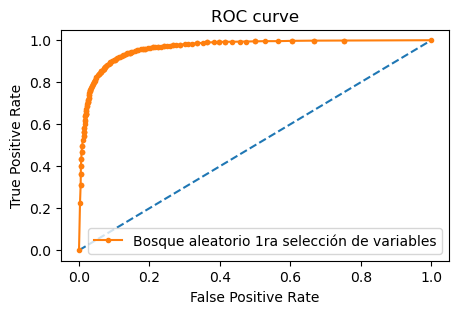

In [159]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_AT)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

**Modelo con variables de la segunda selección.**

Accuracy del test: 0.8678
La sensitividad(recall) del test es: 0.8673
La precisión del test es: 0.8621


Predicción,No,Sí
Observación,,
No,3732,566
Sí,541,3537


Model: ROC AUC = 0.939


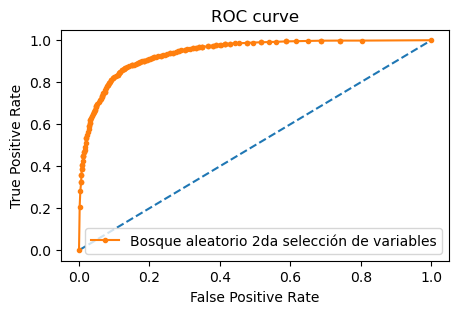

In [160]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_AT)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

In [161]:
#Guardar modelo
print('Variables del modelo:', X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/model_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl']

### Excluir variables de ejecución

In [162]:
X_prestacion = X_prestacion.drop(columns=vars_ejecucion)

Selección de variables

In [163]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_defensa', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Jul', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Ago', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion del Proceso_Mar', 'Codigo Segmento Categoria Principal_70000000', 'Codigo Segmento Categoria Principal_85000000']


In [164]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Mes Firma Contrato_Feb']


Bosque aleatorio

Accuracy del test: 0.8138
La sensitividad(recall) del test es: 0.8212
La precisión del test es: 0.8012


Predicción,No,Sí
Observación,,
No,3467,831
Sí,729,3349


Model: ROC AUC = 0.897


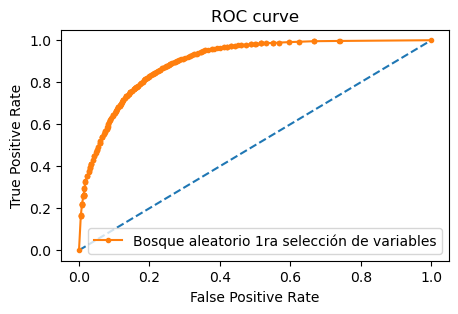

In [165]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_AT)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

Accuracy del test: 0.7185
La sensitividad(recall) del test es: 0.7217
La precisión del test es: 0.7064


Predicción,No,Sí
Observación,,
No,3075,1223
Sí,1135,2943


Model: ROC AUC = 0.803


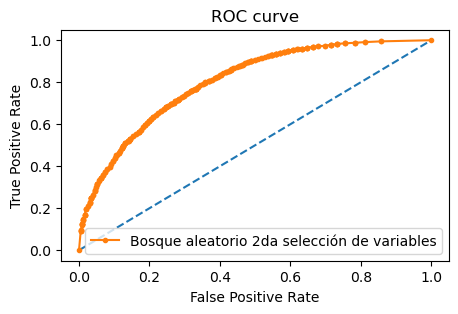

In [166]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_AT)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

Guardar modelo

In [167]:
#Guardar modelo
print('Variables del modelo:', X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Dias Proveedor Inscrito',
       'Mes Firma Contrato_Feb'],
      dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoPreServicios_rf.pkl']

## Modelos para contratos diferentes a prestación de servicios

In [168]:
X_NOprestacion_AT= df_downsampled_AT[df_downsampled_AT["Tipo de Contrato"] != "Prestación de servicios"]
y_NOprestacion_AT = X_NOprestacion_AT["Tuvo_adiciones_tiempo"]

X_NOprestacion_AT = X_NOprestacion_AT.drop(columns = vars_a_excluir+["Tipo de Contrato"])
X_NOprestacion_AT = pd.get_dummies(data = X_NOprestacion_AT, columns = vars_categoricas)

In [169]:
X_NOprestacion_AT.shape

(3368, 189)

### Selección de variables

In [170]:
X_fselec_NOprestacion_AT = feature_selection(X_NOprestacion_AT, y_NOprestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación Directa (con ofertas)', 'Modalidad de Contratacion_Contratación régimen especial', 'Modalidad de Contratacion_Mínima cuantía', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_Presupuesto inferior al 10% de la menor cuantía', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos'

In [171]:
X_fselec_NOprestacion_AT2 = feature_selection(X_fselec_NOprestacion_AT, y_NOprestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017']


In [172]:
X_fselec_NOprestacion_AT2.shape

(3368, 8)

### Bosque aleatorio

Usando solo la segunda selección de variables.

Accuracy del test: 0.8773
La sensitividad(recall) del test es: 0.9073
La precisión del test es: 0.8928


Predicción,No,Sí
Observación,,
No,329,67
Sí,57,558


Model: ROC AUC = 0.944


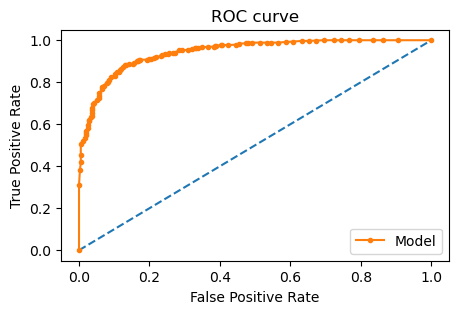

In [173]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion_AT2, 
                                                                                                 y_NOprestacion_AT)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

In [174]:
#Guardar modelo
print('Variables del modelo:', X_fselec_NOprestacion_AT2.columns)
filename = 'created_data/trained_models/model_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
       'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion',
       'Dias Proveedor Inscrito',
       'Justificacion Modalidad de Contratacion_Decreto 092 de 2017'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl']

### Excluir variables de ejecucion

In [175]:
X_NOprestacion_AT = X_NOprestacion_AT.drop(columns=vars_ejecucion)

Selección de variables

In [176]:
X_fselec_NOprestacion_AT = feature_selection(X_NOprestacion_AT, y_NOprestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación Directa (con ofertas)', 'Modalidad de Contratacion_Contratación régimen especial', 'Modalidad de Contratacion_Contratación régimen especial (con ofertas)', 'Modalidad de Contratacion_Mínima cuantía', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_Presupuesto inferior al 10% de la menor cuantía', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Ago', 'M

In [177]:
X_fselec_NOprestacion_AT2 = feature_selection(X_fselec_NOprestacion_AT, y_NOprestacion_AT)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Salud y Protección Social', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017']


Bosque aleatorio

Accuracy del test: 0.7310
La sensitividad(recall) del test es: 0.7967
La precisión del test es: 0.7692


Predicción,No,Sí
Observación,,
No,249,147
Sí,125,490


Model: ROC AUC = 0.802


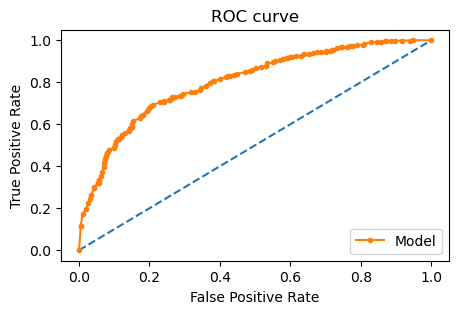

In [178]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion_AT2, 
                                                                                                 y_NOprestacion_AT)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

Guardar modelo

In [179]:
#Guardar modelo
print('Variables del modelo:', X_fselec_NOprestacion_AT2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto',
       'Sector_Salud y Protección Social',
       'Justificacion Modalidad de Contratacion_Decreto 092 de 2017'],
      dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_AdTiempo_TipoContratoNOPreServicios_rf.pkl']

# `Tuvo_adiciones` como variable respuesta

In [180]:
# El patrón "_A" al final indica que corresponde la presencia de Adiciones, de cualquier tipo.
df_downsampled_A = balance(base, "Tuvo_adiciones")

X_down = pd.get_dummies(data = df_downsampled_A, columns = vars_categoricas+["Tipo de Contrato"])
X_down = X_down.drop(columns = vars_a_excluir)

y3_down_A = df_downsampled_A["Tuvo_adiciones"]

In [181]:
df_downsampled_A.shape

(56546, 41)

## Modelos sin diferenciar tipo de contrato

### Selección de variables

In [182]:
X_fselec = feature_selection(X_down, y3_down_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_Transporte', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Mes de Publicacion del Proceso_Abr', 'Mes de

In [183]:
X_fselec2 = feature_selection(X_fselec, y3_down_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']


### Regresión logística

Accuracy para Regresión Logística con validación cruzada: 0.6615 
El accuracy del test es: 0.6664
La sensitividad(recall) del test es: 0.6622
La precisión del test es: 0.6678
BIC: 75.33
AIC: 15.22


Predicción,No,Sí
Observación,,
No,5688,2794
Sí,2865,5617


Model: ROC AUC = 0.729


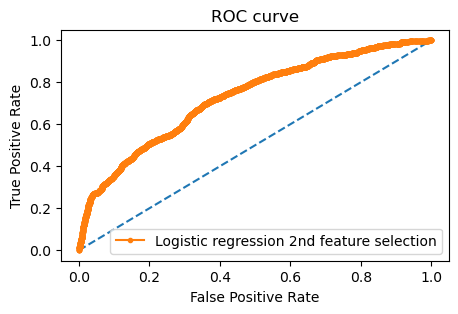

In [184]:
regLog3, X_test3, y_test3, y_pred3, scaler3 = reg_log(X_fselec2, y3_down_A)

plot_CM(y_test3, y_pred3)
plot_ROC(regLog3, X_test3, y_test3, scaler3, model_name='Logistic regression 2nd feature selection')

### Bosque aleatorio

**Modelo con variables de la primera selección.**

Accuracy del test: 0.8952
La sensitividad(recall) del test es: 0.8833
La precisión del test es: 0.9049


Predicción,No,Sí
Observación,,
No,7695,787
Sí,990,7492


Model: ROC AUC = 0.958


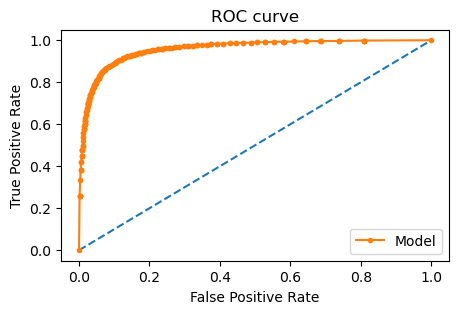

In [185]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y3_down_A)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler)

**Modelo con variables de la segunda selección.**

Accuracy del test: 0.8588
La sensitividad(recall) del test es: 0.8402
La precisión del test es: 0.8726


Predicción,No,Sí
Observación,,
No,7441,1041
Sí,1355,7127


Model: ROC AUC = 0.933


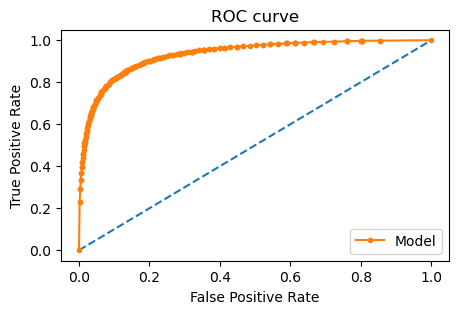

In [186]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2, X_train2, y_train2 = random_forest(X_fselec2, y3_down_A, get_train=True)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2)

#### Importancia de variables

In [187]:
forest_importances = pd.Series(forest2.feature_importances_,
                               index=X_fselec2.columns)
forest_importances.sort_values(ascending=False)

Dias Fin-Inicio Ejecucion      0.232274
Dias Fin-Inicio Contrato       0.221590
Valor del Contrato             0.170384
Dias Proveedor Inscrito        0.169661
Dias Inicio-Firma Ejecucion    0.123087
Dias Inicio-Firma Contrato     0.083004
dtype: float64

Wall time: 8min 32s


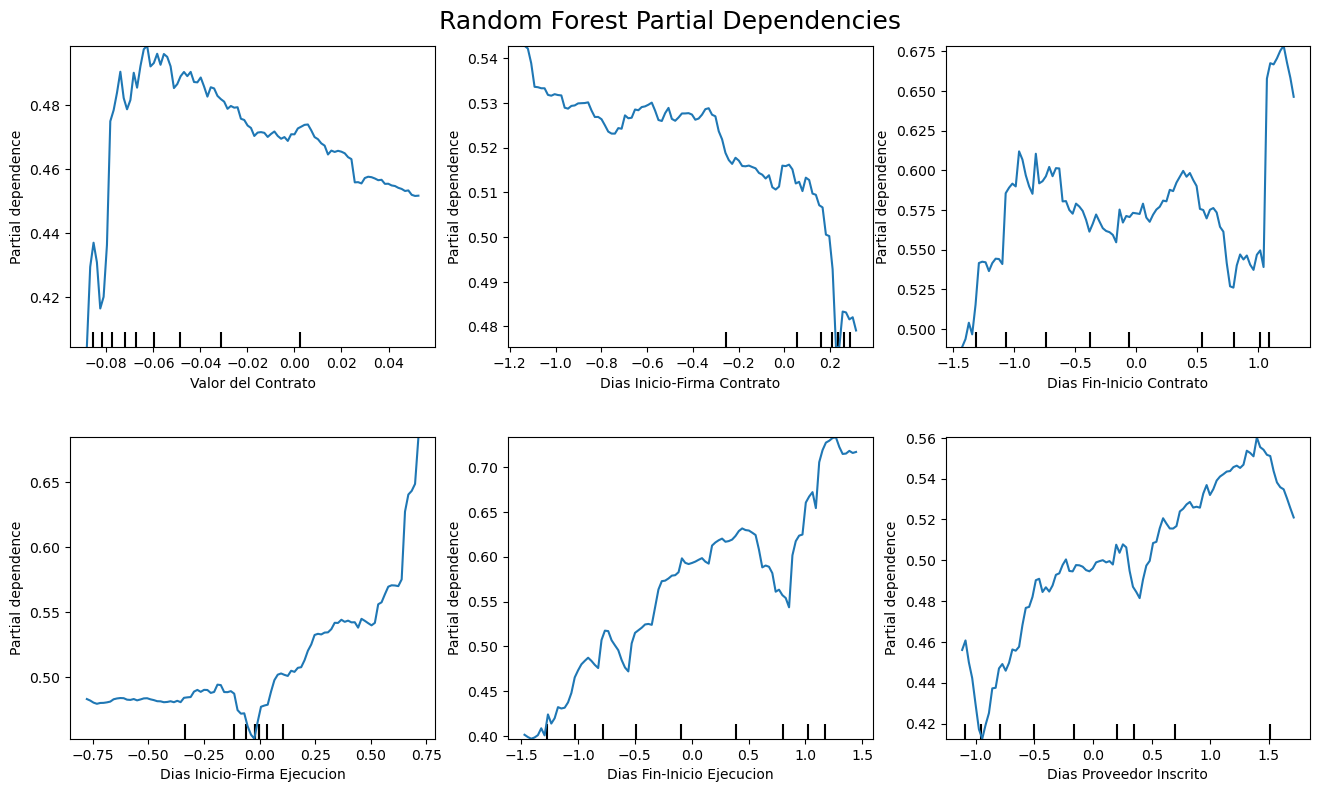

In [188]:
%%time
X_train_sc = pd.DataFrame(scaler2.transform(X_train2), columns=X_train2.columns)
variables = list(X_train2.columns)
eng_vars = ['Contract value', 'Sign-start contract days', 'Start-end contract days',
           'Sign-start execution days', 'Start-end execution days',
           'Days provider registered']
eng_vars = dict(zip(variables, eng_vars))

plt.figure(figsize=(16, 9))
plt.subplots_adjust(hspace=0.3)
plt.suptitle('Random Forest Partial Dependencies', fontsize=18, y=0.92)
for n, var in enumerate(variables):
    ax = plt.subplot(2, 3, n + 1)
    plot_partial_dependence(forest2, X_train_sc, [var], ax=ax)
    ax.set_xlabel(eng_vars[var], fontsize=12)
plt.savefig('created_data/figures/PDP_RF_Adiciones.svg')

In [189]:
#Guardar modelo
print('Variables del modelo:', X_fselec2.columns)
filename = 'created_data/trained_models/model_secopII_Adiciones_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_Adiciones_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_Adiciones_TipoContratoTodos_rf.pkl']

### Comparación de modelos
Bosque aleatorio vs regresión logística con segunda selección de variables, adiciones.

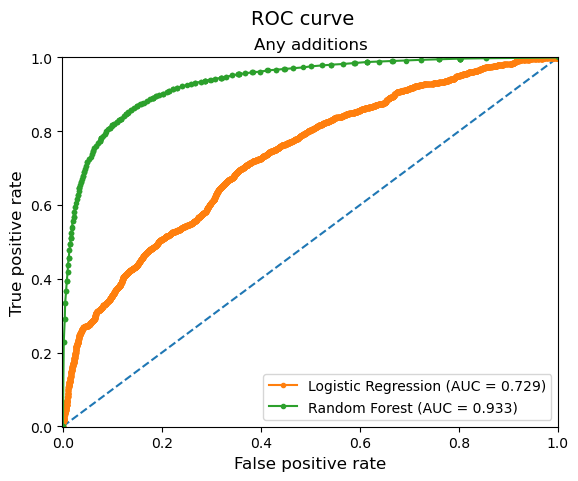

In [190]:
# Crear predicciones
ns_probs = [0 for _ in range(len(y_test2))]
lr_probs = regLog3.predict_proba(scaler3.transform(X_test2))[:, 1]
rf_probs = forest2.predict_proba(scaler2.transform(X_test2))[:, 1]

lr_auc = roc_auc_score(y_test2, lr_probs)
rf_auc = roc_auc_score(y_test2, rf_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test2, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test2, rf_probs)

#plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
plt.plot(lr_fpr, lr_tpr, marker = '.', label = 'Logistic Regression (AUC = {:1.3F})'.format(lr_auc))
plt.plot(rf_fpr, rf_tpr, marker = '.', label = 'Random Forest (AUC = {:1.3F})'.format(rf_auc))
plt.xlim([-0.001,1.001])
plt.ylim([-0.001,1.001])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right")
plt.suptitle('ROC curve', fontsize=14)
plt.title('Any additions')

# plt.savefig('created_data/figures/ROC_Adiciones_muestracompleta.png')
plt.savefig('created_data/figures/ROC_Adiciones_muestracompleta.svg')

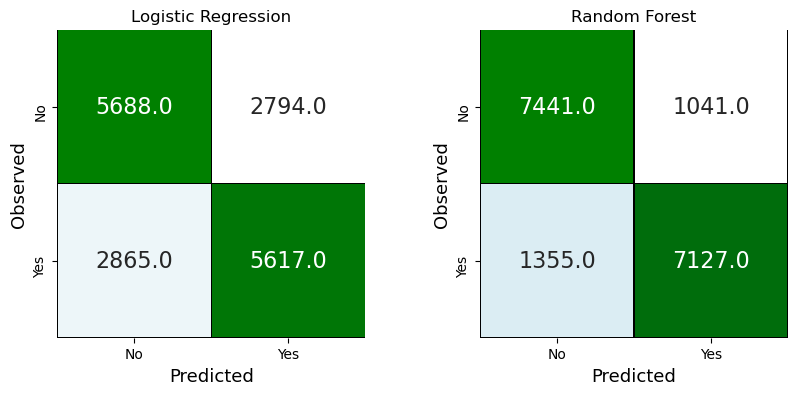

In [191]:
plt.figure(figsize=(10,4))

plt.subplot(121)
cm = confusion_matrix(y_test3, y_pred3)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Logistic Regression')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

plt.subplot(122)
cm = confusion_matrix(y_test2, y_pred_forest2)
cm_df = pd.DataFrame(cm, index = ['No','Yes'], columns = ['No','Yes'])

sns.heatmap( cm_df, 
            annot=True, fmt='2.1f', cmap='ocean_r',annot_kws={'fontsize':16},
            cbar=False, square=True, linecolor='black', linewidths=0.2 )
plt.title('Random Forest')
plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Observed', fontsize=13)

# plt.savefig('created_data/figures/MatConf_AValor_muestracompleta.png')
plt.savefig('created_data/figures/MatConf_Adiciones_muestracompleta.svg')

### Excluir variables de ejecución

In [192]:
X_down = X_down.drop(columns=vars_ejecucion)

Seleccionar variables

In [193]:
X_fselec = feature_selection(X_down, y3_down_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Sector_defensa', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Abr', 'Mes de Publicacion del Proceso_Ago', 'Mes de Publicacion del Pr

In [194]:
X_fselec2 = feature_selection(X_fselec, y3_down_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito']


Bosque aleatorio

Accuracy del test: 0.7840
La sensitividad(recall) del test es: 0.7855
La precisión del test es: 0.7831


Predicción,No,Sí
Observación,,
No,6636,1846
Sí,1819,6663


Model: ROC AUC = 0.871


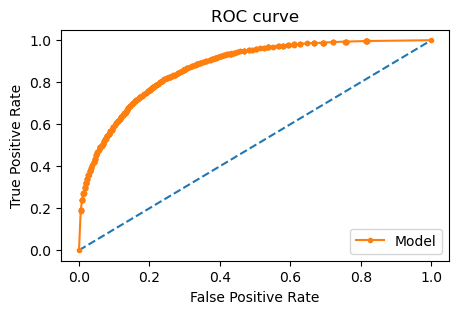

In [195]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec, y3_down_A)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler)

Accuracy del test: 0.6634
La sensitividad(recall) del test es: 0.6679
La precisión del test es: 0.6620


Predicción,No,Sí
Observación,,
No,5589,2893
Sí,2817,5665


Model: ROC AUC = 0.737


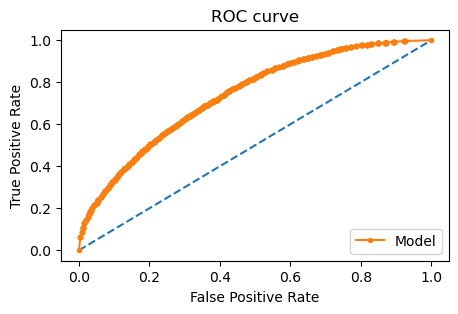

In [196]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec2, y3_down_A)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2)

Guardar modelo

In [197]:
#Guardar modelo
print('Variables del modelo:', X_fselec2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_Adiciones_TipoContratoTodos_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoTodos_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables del modelo: Index(['Valor del Contrato', 'Dias Proveedor Inscrito'], dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoTodos_rf.pkl']

## Modelos para contratos de prestación de servicios
Se filtran las observaciones por la variable `Tipo de Contrato` conservando aquellos del tipo "Prestación de servicios".

In [198]:
X_prestacion = df_downsampled_A[df_downsampled_A["Tipo de Contrato"] == "Prestación de servicios"]
y_prestacion_A = X_prestacion["Tuvo_adiciones"]

X_prestacion = X_prestacion.drop(columns = vars_a_excluir+["Tipo de Contrato"])
X_prestacion = pd.get_dummies(data = X_prestacion, columns = vars_categoricas)

### Selección de variables

In [199]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Mes de Publicacion del Proceso_Abr', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso_Feb', 'Mes de Publicacion del Proceso_Mar', 'Codigo Segm

In [200]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']


### Bosque aleatorio

**Modelo con las variables de la primera selección**

Accuracy del test: 0.8968
La sensitividad(recall) del test es: 0.8817
La precisión del test es: 0.9085


Predicción,No,Sí
Observación,,
No,7046,681
Sí,907,6760


Model: ROC AUC = 0.959


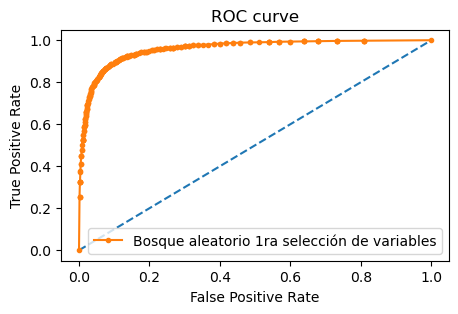

In [201]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_A)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

**Modelo con las variables de la segunda selección**

Accuracy del test: 0.8644
La sensitividad(recall) del test es: 0.8503
La precisión del test es: 0.8741


Predicción,No,Sí
Observación,,
No,6788,939
Sí,1148,6519


Model: ROC AUC = 0.938


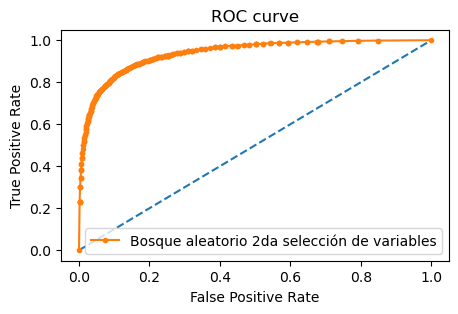

In [202]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_A)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

In [203]:
#Guardar modelo
print('Variables de modelos:', X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/model_secopII_Adiciones_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_Adiciones_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables de modelos: Index(['Valor del Contrato', 'Dias Inicio-Firma Contrato',
       'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion',
       'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_Adiciones_TipoContratoPreServicios_rf.pkl']

### Excluir variables de ejecución

In [204]:
X_prestacion = X_prestacion.drop(columns=vars_ejecucion)

Selección de variables

In [205]:
X_fselec_Pservicios = feature_selection(X_prestacion, y_prestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito', 'Sector_Ambiente y Desarrollo Sostenible', 'Sector_Cultura', 'Sector_No aplica/No pertenece', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación directa', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'Justificacion Modalidad de Contratacion_ServiciosProfesionales', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Mes Firma Contrato_Abr', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Ene', 'Mes Firma Contrato_Feb', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Servicios administrativos', 'Grupo categoria principal_Servicios(No Admin)', 'Mes de Publicacion del Proceso_Abr', 'Mes de Publicacion del Proceso_Ago', 'Mes de Publicacion del Proceso_Ene', 'Mes de Publicacion del Proceso

In [206]:
X_fselec_Pservicios2 = feature_selection(X_fselec_Pservicios, y_prestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Dias Proveedor Inscrito']


Bosque aleatorio

Accuracy del test: 0.7870
La sensitividad(recall) del test es: 0.7899
La precisión del test es: 0.7840


Predicción,No,Sí
Observación,,
No,6059,1668
Sí,1611,6056


Model: ROC AUC = 0.873


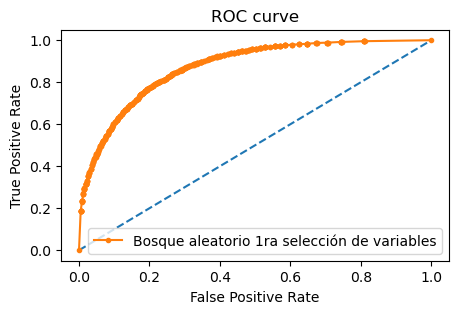

In [207]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_fselec_Pservicios, y_prestacion_A)

plot_CM(y_test, y_pred_forest)
plot_ROC(forest, X_test, y_test, scaler, 
         model_name='Bosque aleatorio 1ra selección de variables')

Accuracy del test: 0.6772
La sensitividad(recall) del test es: 0.6777
La precisión del test es: 0.6753


Predicción,No,Sí
Observación,,
No,5229,2498
Sí,2471,5196


Model: ROC AUC = 0.750


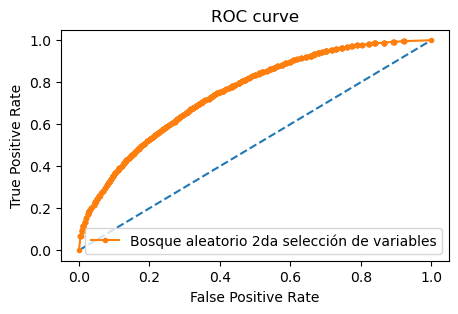

In [208]:
forest2, X_test2, y_test2, y_pred_forest2, scaler2 = random_forest(X_fselec_Pservicios2, y_prestacion_A)

plot_CM(y_test2, y_pred_forest2)
plot_ROC(forest2, X_test2, y_test2, scaler2, 
         model_name='Bosque aleatorio 2da selección de variables')

Guardar modelo

In [209]:
#Guardar modelo
print('Variables de modelos:', X_fselec_Pservicios2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_Adiciones_TipoContratoPreServicios_rf.pkl'
joblib.dump(forest2, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoPreServicios_rf.pkl'
joblib.dump(scaler2, filename_scaler)

Variables de modelos: Index(['Valor del Contrato', 'Dias Proveedor Inscrito'], dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoPreServicios_rf.pkl']

## Modelos para contratos diferentes a prestación de servicios

In [210]:
X_NOprestacion_A = df_downsampled_A[df_downsampled_A["Tipo de Contrato"] != "Prestación de servicios"]
y_NOprestacion_A = X_NOprestacion_A["Tuvo_adiciones"]

X_NOprestacion_A = X_NOprestacion_A.drop(columns = vars_a_excluir+["Tipo de Contrato"])
X_NOprestacion_A = pd.get_dummies(data = X_NOprestacion_A, columns = vars_categoricas)

In [211]:
X_NOprestacion_A.shape

(5235, 194)

### Selección de variables

In [212]:
X_fselec_NOprestacion_A = feature_selection(X_NOprestacion_A, y_NOprestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación régimen especial', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_Presupuesto inferior al 10% de la menor cuantía', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Liquidación_No', 'Liquidación_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Dic', 'Mes Firma Contrato_Mar', 'Grupo categoria principal_Productos

In [213]:
X_fselec_NOprestacion_A2 = feature_selection(X_fselec_NOprestacion_A, y_NOprestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato', 'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']


In [214]:
X_fselec_NOprestacion_A2.shape

(5235, 7)

### Bosque aleatorio

Usando la segunda selección de variables.

Accuracy del test: 0.8300
La sensitividad(recall) del test es: 0.8260
La precisión del test es: 0.8436


Predicción,No,Sí
Observación,,
No,630,125
Sí,142,674


Model: ROC AUC = 0.917


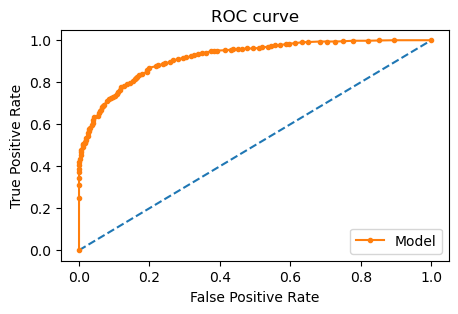

In [215]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion_A2, 
                                                                                                 y_NOprestacion_A)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

In [216]:
#Guardar modelo
print('Variables de modelos:', X_fselec_NOprestacion_A2.columns)
filename = 'created_data/trained_models/model_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/scaler_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables de modelos: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Inicio-Firma Contrato', 'Dias Fin-Inicio Contrato',
       'Dias Inicio-Firma Ejecucion', 'Dias Fin-Inicio Ejecucion',
       'Dias Proveedor Inscrito'],
      dtype='object')


['CreatedData/trained_models/scaler_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl']

### Excluir variables de ejecución

In [217]:
X_NOprestacion_A = X_NOprestacion_A.drop(columns=vars_ejecucion)

Selección de variables

In [218]:
X_fselec_NOprestacion_A = feature_selection(X_NOprestacion_A, y_NOprestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto', 'Sector_Cultura', 'Sector_Salud y Protección Social', 'Sector_Servicio Público', 'Entidad Centralizada_Centralizada', 'Entidad Centralizada_Descentralizada', 'Modalidad de Contratacion_Contratación régimen especial', 'Modalidad de Contratacion_Mínima cuantía', 'Justificacion Modalidad de Contratacion_Decreto 092 de 2017', 'Justificacion Modalidad de Contratacion_Presupuesto inferior al 10% de la menor cuantía', 'Justificacion Modalidad de Contratacion_Regla aplicable', 'TipoDocProveedor_Cédula de Ciudadanía', 'TipoDocProveedor_NIT', 'Es Pyme_No', 'Es Pyme_Si', 'Destino Gasto_Funcionamiento', 'Destino Gasto_Inversión', 'Tipo Empresa Proveedor_Persona Natural colombiana', 'Mes Firma Contrato_Ago', 'Mes Firma Contrato_Dic', 'Mes Firma Contrato_Jul', 'Mes Firma Contrato_Mar', 'Mes Firma Contrato_Nov', 'Mes Firma Contrato_Oct', 'Mes Firm

In [219]:
X_fselec_NOprestacion_A2 = feature_selection(X_fselec_NOprestacion_A, y_NOprestacion_A)

Variables estadísticamente significativas: 
['Valor del Contrato', 'Proveedores Invitados', 'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto']


Bosque aleatorio

Accuracy del test: 0.6703
La sensitividad(recall) del test es: 0.6863
La precisión del test es: 0.6813


Predicción,No,Sí
Observación,,
No,493,262
Sí,256,560


Model: ROC AUC = 0.745


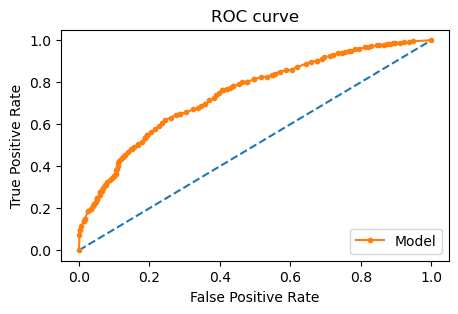

In [220]:
forest_noserv, X_test_noserv, y_test_noserv, y_pred_forest_noserv, scaler_noserv = random_forest(X_fselec_NOprestacion_A2, 
                                                                                                 y_NOprestacion_A)

plot_CM(y_test_noserv, y_pred_forest_noserv)
plot_ROC(forest_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

Guardar modelo

In [221]:
#Guardar modelo
print('Variables de modelos:', X_fselec_NOprestacion_A2.columns)
filename = 'created_data/trained_models/modelos_preejecucion/model_preejec_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(forest_noserv, filename)

filename_scaler = 'created_data/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl'
joblib.dump(scaler_noserv, filename_scaler)

Variables de modelos: Index(['Valor del Contrato', 'Proveedores Invitados',
       'Dias Proveedor Inscrito', 'Dias Proceso Contratacion Abierto'],
      dtype='object')


['CreatedData/trained_models/modelos_preejecucion/scaler_preejec_secopII_Adiciones_TipoContratoNOPreServicios_rf.pkl']